In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
%cd /content/drive/My\ Drive/DTI/Input

In [ ]:
!pip install git+https://github.com/palash1992/GEM.git
!pip install tensorflow==1.13.1

In [ ]:
from data_loading import *
from utils import *
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
from gem.embedding.sdne import SDNE
from gem.embedding.hope import HOPE
from gem.embedding.lap import LaplacianEigenmaps
from gem.embedding.gf import GraphFactorization
from gem.embedding.lle import LocallyLinearEmbedding
from gem.evaluation import visualize_embedding as viz
from gem.evaluation import evaluate_graph_reconstruction as gr
from gem.utils import graph_util, plot_util
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from time import time
%matplotlib inline

In [ ]:
all_drugs, all_targets, drug_similarity_matrices, target_similarity_matrices, DTIs, DT_labeled, X, Y = load_datasets('e')

Number of drugs: 445
Number of targets: 664
Loading only selected similarity matrices
Dimensions of all pairs: (295480, 2)


In [ ]:
all_negative_pairs = []
all_positive_pairs = []
for target_id in range(len(all_targets)):
  for drug_id in range(len(all_drugs)):
    if DTIs[target_id][drug_id] == 1:
      all_positive_pairs.append((drug_id, target_id))
    else:
      all_negative_pairs.append((drug_id, target_id))

In [ ]:
models = []
filenames = ['hope', 'lap', 'lle']#, 'sdne']
# HOPE takes embedding dimension (d) and decay factor (beta) as inputs
models.append(HOPE(d=36, beta=0.01))
# LE takes embedding dimension (d) as input
models.append(LaplacianEigenmaps(d=36))
# LLE takes embedding dimension (d) as input
models.append(LocallyLinearEmbedding(d=36))
# SDNE takes embedding dimension (d), seen edge reconstruction weight (beta), first order proximity weight (alpha), lasso regularization coefficient (nu1), ridge regreesion coefficient (nu2), number of hidden layers (K), size of each layer (n_units), number of iterations (n_ite), learning rate (xeta), size of batch (n_batch), location of modelfile and weightfile save (modelfile and weightfile) as inputs
# models.append(SDNE(d=36, beta=5, alpha=1e-5, nu1=1e-6, nu2=1e-6, K=3, n_units=[30, 15,], n_iter=25, xeta=0.01, n_batch=150,
                # modelfile=['enc_model.json', 'dec_model.json'], weightfile=['enc_weights.hdf5', 'dec_weights.hdf5']))

In [ ]:
ada_boost = AdaBoostClassifier(DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=6, min_samples_split=2,
                                                      min_samples_leaf=1, max_features=None, random_state=1,
                                                      max_leaf_nodes=None, min_impurity_split=None), algorithm="SAMME",
                                                      n_estimators=100, random_state=0)

In [ ]:
xgb = XGBClassifier(max_depth=8, min_child_weight=2, n_estimators=200, gamma=0.1, random_state=0)

In [ ]:
ann = MLPClassifier(activation='relu', solver='adam', alpha=1e-5, hidden_layer_sizes=(24, 8), learning_rate='adaptive', random_state=0)

In [ ]:
fused_DD_similarities_SNF = SNF(drug_similarity_matrices, K=5, t=3, alpha=1.0)
fused_TT_similarities_SNF = SNF(target_similarity_matrices, K=5, t=3, alpha=1.0)

fused_DD_similarities_avg = avg_matrix(drug_similarity_matrices)
fused_TT_similarities_avg = avg_matrix(target_similarity_matrices)

fused_DD_similarities_max = max_matrix(drug_similarity_matrices)
fused_TT_similarities_max = max_matrix(target_similarity_matrices)

In [ ]:
chosen_negative_pairs_SNF = choose_negative_pairs(all_negative_pairs, DTIs, fused_DD_similarities_SNF, fused_TT_similarities_SNF, len(all_positive_pairs))

chosen_negative_pairs_avg = choose_negative_pairs(all_negative_pairs, DTIs, fused_DD_similarities_avg, fused_TT_similarities_avg, len(all_positive_pairs))

chosen_negative_pairs_max = choose_negative_pairs(all_negative_pairs, DTIs, fused_DD_similarities_max, fused_TT_similarities_max, len(all_positive_pairs))

In [ ]:
print(f'Number of positive pairs: {len(all_positive_pairs)}')

print(f'[SNF] Number of negative pairs: {len(chosen_negative_pairs_SNF)}')
print(f'[AVG] Number of negative pairs: {len(chosen_negative_pairs_avg)}')
print(f'[MAX] Number of negative pairs: {len(chosen_negative_pairs_max)}')

Number of positive pairs: 2926
[SNF] Number of negative pairs: 2926
[AVG] Number of negative pairs: 2926
[MAX] Number of negative pairs: 2926


In [ ]:
all_positive_pairs_edges = [(drug_id, target_id + len(all_drugs)) for (drug_id, target_id) in all_positive_pairs]

chosen_negative_pairs_edges_SNF = [(drug_id, target_id + len(all_drugs)) for (drug_id, target_id) in chosen_negative_pairs_SNF]
chosen_negative_pairs_edges_avg = [(drug_id, target_id + len(all_drugs)) for (drug_id, target_id) in chosen_negative_pairs_avg]
chosen_negative_pairs_edges_max = [(drug_id, target_id + len(all_drugs)) for (drug_id, target_id) in chosen_negative_pairs_max]

---
### Graph initialization and primary visualizations

Nodes: 1109
Edges: 2926
Number of connected components: 44
Size of each component (number of nodes): [809, 58, 32, 25, 19, 16, 13, 12, 8, 8, 7, 7, 6, 6, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Nodes in largest connected component: 809
Edges in largest connected component: 2556


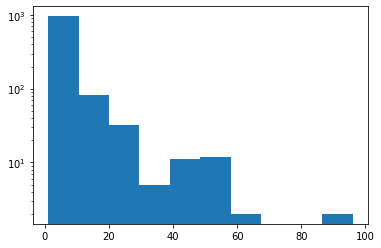

In [ ]:
# all graphs are the same as of right now, that's why we are showing only graph_SNF info and visualizations
graph_SNF = nx.Graph()
graph_avg = nx.Graph()
graph_max = nx.Graph()
for u, v in all_positive_pairs_edges:
    graph_SNF.add_edge(u, v, weight=1)
    graph_avg.add_edge(u, v, weight=1)
    graph_max.add_edge(u, v, weight=1)

color_map = []
for node in graph_SNF:
  # drug
  if node < len(all_drugs):
    color_map.append("blue")
  # target
  else:
    color_map.append("red")

node_sizes = [30] * graph_SNF.number_of_nodes()

calculate_statistics(graph_SNF)

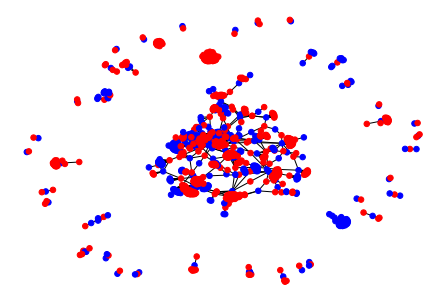

In [ ]:
nx.draw(graph_SNF, node_color=color_map, node_size=node_sizes)

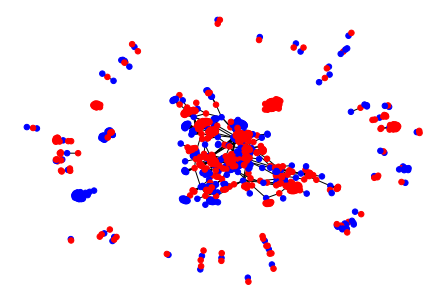

In [ ]:
nx.draw_spring(graph_SNF, node_color=color_map, node_size=node_sizes)

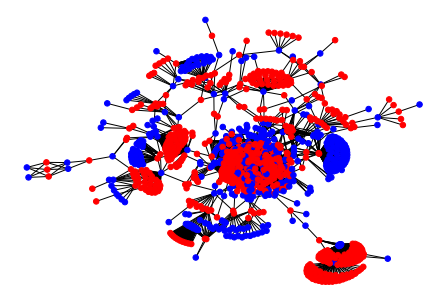

In [ ]:
nx.draw_kamada_kawai(graph_SNF, node_color=color_map, node_size=node_sizes)

---
### Add strongest similarities edges to graph

In [ ]:
strongest_drug_similarities_edges_SNF = get_strongest_all_p_similarities(fused_DD_similarities_SNF, 5)
strongest_target_similarities_edges_SNF = get_strongest_all_p_similarities(fused_TT_similarities_SNF, 5)

strongest_drug_similarities_edges_avg = get_strongest_all_p_similarities(fused_DD_similarities_avg, 5)
strongest_target_similarities_edges_avg = get_strongest_all_p_similarities(fused_TT_similarities_avg, 5)

strongest_drug_similarities_edges_max = get_strongest_all_p_similarities(fused_DD_similarities_max, 5)
strongest_target_similarities_edges_max = get_strongest_all_p_similarities(fused_TT_similarities_max, 5)

In [ ]:
for drug_id1, drug_id2 in strongest_drug_similarities_edges_SNF:
  graph_SNF.add_edge(drug_id1, drug_id2, weight=fused_DD_similarities_SNF[drug_id1][drug_id2])
for target_id1, target_id2 in strongest_target_similarities_edges_SNF:
  graph_SNF.add_edge(target_id1 + len(all_drugs), target_id2 + len(all_drugs), weight=fused_TT_similarities_SNF[target_id1][target_id2])

for drug_id1, drug_id2 in strongest_drug_similarities_edges_avg:
  graph_avg.add_edge(drug_id1, drug_id2, weight=fused_DD_similarities_avg[drug_id1][drug_id2])
for target_id1, target_id2 in strongest_target_similarities_edges_avg:
  graph_avg.add_edge(target_id1 + len(all_drugs), target_id2 + len(all_drugs), weight=fused_TT_similarities_avg[target_id1][target_id2])

for drug_id1, drug_id2 in strongest_drug_similarities_edges_max:
  graph_max.add_edge(drug_id1, drug_id2, weight=fused_DD_similarities_max[drug_id1][drug_id2])
for target_id1, target_id2 in strongest_target_similarities_edges_max:
  graph_max.add_edge(target_id1 + len(all_drugs), target_id2 + len(all_drugs), weight=fused_TT_similarities_max[target_id1][target_id2])

---
### Graph visualizations (after adding strongest similarities edges)

SNF graph
Nodes: 1109
Edges: 18870
Number of connected components: 1
Size of each component (number of nodes): [1109]
Nodes in largest connected component: 1109
Edges in largest connected component: 18870


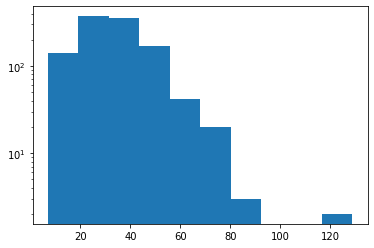

In [ ]:
print('SNF graph')
calculate_statistics(graph_SNF)

SNF graph


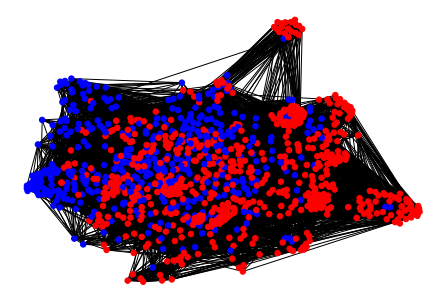

In [ ]:
print('SNF graph')
nx.draw(graph_SNF, node_color=color_map, node_size=node_sizes)

SNF graph


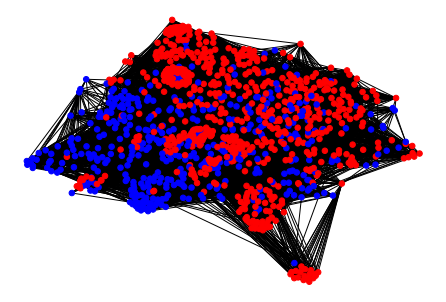

In [ ]:
print('SNF graph')
nx.draw_spring(graph_SNF, node_color=color_map, node_size=node_sizes)

SNF graph


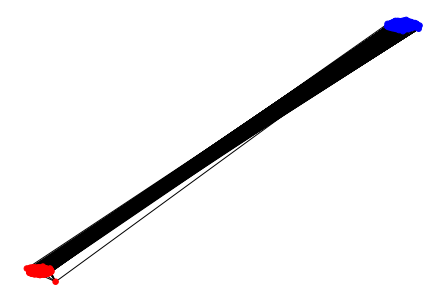

In [ ]:
print('SNF graph')
nx.draw_kamada_kawai(graph_SNF, node_color=color_map, node_size=node_sizes)

AVG graph
Nodes: 1109
Edges: 18870
Number of connected components: 1
Size of each component (number of nodes): [1109]
Nodes in largest connected component: 1109
Edges in largest connected component: 18870


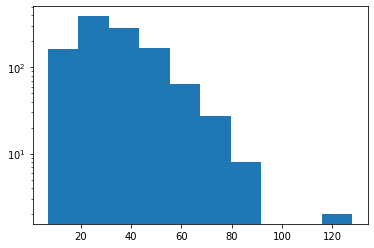

In [ ]:
print('AVG graph')
calculate_statistics(graph_avg)

AVG graph


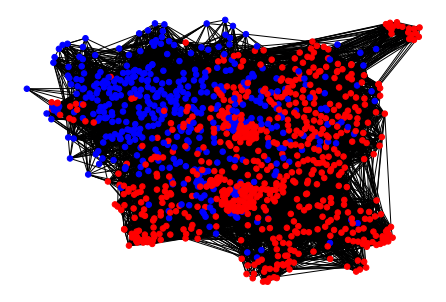

In [ ]:
print('AVG graph')
nx.draw(graph_avg, node_color=color_map, node_size=node_sizes)

AVG graph


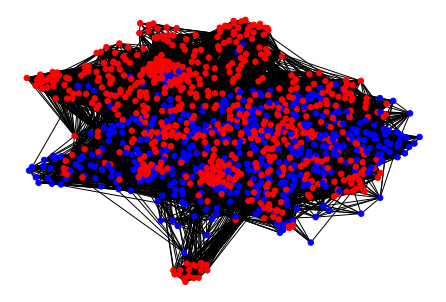

In [ ]:
print('AVG graph')
nx.draw_spring(graph_avg, node_color=color_map, node_size=node_sizes)

AVG graph


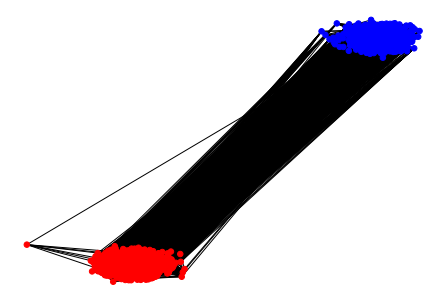

In [ ]:
print('AVG graph')
nx.draw_kamada_kawai(graph_avg, node_color=color_map, node_size=node_sizes)

MAX graph
Nodes: 1109
Edges: 18870
Number of connected components: 1
Size of each component (number of nodes): [1109]
Nodes in largest connected component: 1109
Edges in largest connected component: 18870


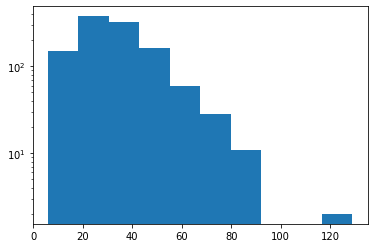

In [ ]:
print('MAX graph')
calculate_statistics(graph_max)

MAX graph


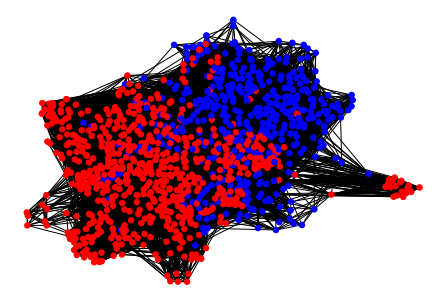

In [ ]:
print('MAX graph')
nx.draw(graph_max, node_color=color_map, node_size=node_sizes)

MAX graph


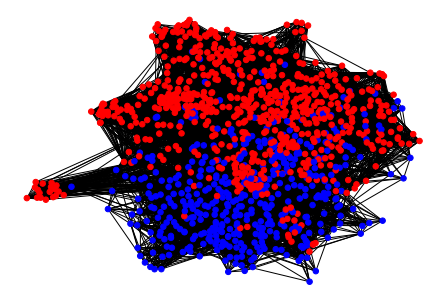

In [ ]:
print('MAX graph')
nx.draw_spring(graph_max, node_color=color_map, node_size=node_sizes)

MAX graph


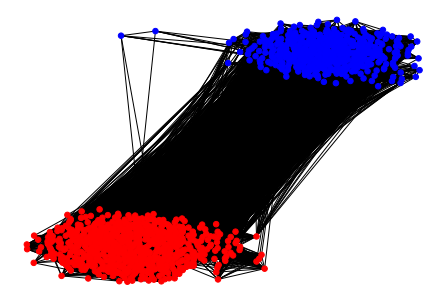

In [ ]:
print('MAX graph')
nx.draw_kamada_kawai(graph_max, node_color=color_map, node_size=node_sizes)

---
### Initialize skf and generate test edges and target labels

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

test_edges_SNF = np.array(all_positive_pairs_edges + chosen_negative_pairs_edges_SNF)
target_label_SNF = np.array([1] * len(all_positive_pairs_edges) + [0] * len(chosen_negative_pairs_edges_SNF))

test_edges_avg = np.array(all_positive_pairs_edges + chosen_negative_pairs_edges_avg)
target_label_avg = np.array([1] * len(all_positive_pairs_edges) + [0] * len(chosen_negative_pairs_edges_avg))

test_edges_max = np.array(all_positive_pairs_edges + chosen_negative_pairs_edges_max)
target_label_max = np.array([1] * len(all_positive_pairs_edges) + [0] * len(chosen_negative_pairs_edges_max))

---
### Generate embeddings and similarities, and validate generated files

In [ ]:
for (embedding, filename) in zip(models, filenames):
  count = 1
  for train_index, test_index in skf.split(test_edges_SNF, target_label_SNF):
    test_fold_edges, test_fold_labels = test_edges_SNF[test_index], target_label_SNF[test_index]
    graph_copy = graph_SNF.copy()
    with open(f"embeddings/e/{filename}/SNF/folds/fold{count}.csv", "w") as file:
      for edge, label in zip(test_fold_edges, test_fold_labels):
        file.write(f"{edge[0]},{edge[1]},{label}\n")
        if graph_copy.has_edge(edge[0], edge[1]):
          graph_copy.remove_edge(edge[0], edge[1])
      file.close()
    graph_copy = graph_copy.to_directed()
    # Learn embedding - accepts a networkx graph or file with edge list
    embs, t = embedding.learn_embedding(graph=graph_copy, edge_f=None, is_weighted=True, no_python=True)
    save_embeddings(f"embeddings/e/{filename}/SNF/fold{count}.emb", embs, list(graph_copy.nodes()))
    count += 1
    # Evaluate on graph reconstruction
    MAP, prec_curv, err, err_baseline = gr.evaluateStaticGraphReconstruction(graph_copy, embedding, embs, None)
    #---------------------------------------------------------------------------------
    print(("\tMAP: {} \t precision curve: {}\n\n\n\n"+'-'*100).format(MAP, prec_curv[:5]))

for (embedding, filename) in zip(models, filenames):
  count = 1
  for train_index, test_index in skf.split(test_edges_avg, target_label_avg):
    test_fold_edges, test_fold_labels = test_edges_avg[test_index], target_label_avg[test_index]
    graph_copy = graph_avg.copy()
    with open(f"embeddings/e/{filename}/AVG/folds/fold{count}.csv", "w") as file:
      for edge, label in zip(test_fold_edges, test_fold_labels):
        file.write(f"{edge[0]},{edge[1]},{label}\n")
        if graph_copy.has_edge(edge[0], edge[1]):
          graph_copy.remove_edge(edge[0], edge[1])
      file.close()
    graph_copy = graph_copy.to_directed()
    # Learn embedding - accepts a networkx graph or file with edge list
    embs, t = embedding.learn_embedding(graph=graph_copy, edge_f=None, is_weighted=True, no_python=True)
    save_embeddings(f"embeddings/e/{filename}/AVG/fold{count}.emb", embs, list(graph_copy.nodes()))
    count += 1
    # Evaluate on graph reconstruction
    MAP, prec_curv, err, err_baseline = gr.evaluateStaticGraphReconstruction(graph_copy, embedding, embs, None)
    #---------------------------------------------------------------------------------
    print(("\tMAP: {} \t precision curve: {}\n\n\n\n"+'-'*100).format(MAP, prec_curv[:5]))

for (embedding, filename) in zip(models, filenames):
  count = 1
  for train_index, test_index in skf.split(test_edges_max, target_label_max):
    test_fold_edges, test_fold_labels = test_edges_max[test_index], target_label_max[test_index]
    graph_copy = graph_max.copy()
    with open(f"embeddings/e/{filename}/MAX/folds/fold{count}.csv", "w") as file:
      for edge, label in zip(test_fold_edges, test_fold_labels):
        file.write(f"{edge[0]},{edge[1]},{label}\n")
        if graph_copy.has_edge(edge[0], edge[1]):
          graph_copy.remove_edge(edge[0], edge[1])
      file.close()
    graph_copy = graph_copy.to_directed()
    # Learn embedding - accepts a networkx graph or file with edge list
    embs, t = embedding.learn_embedding(graph=graph_copy, edge_f=None, is_weighted=True, no_python=True)
    save_embeddings(f"embeddings/e/{filename}/MAX/fold{count}.emb", embs, list(graph_copy.nodes()))
    count += 1
    # Evaluate on graph reconstruction
    MAP, prec_curv, err, err_baseline = gr.evaluateStaticGraphReconstruction(graph_copy, embedding, embs, None)
    #---------------------------------------------------------------------------------
    print(("\tMAP: {} \t precision curve: {}\n\n\n\n"+'-'*100).format(MAP, prec_curv[:5]))

In [ ]:
# cosine similarity
for filename in filenames:
  for count in range(10):
    per_fold_dd_scores = np.empty(shape=(len(all_drugs), len(all_drugs)))
    per_fold_tt_scores = np.empty(shape=(len(all_targets), len(all_targets)))
    per_fold_dt_scores = np.empty(shape=(len(all_drugs), len(all_targets)))
    embeddings = read_embeddings(f"embeddings/e/{filename}/SNF/fold{count + 1}.emb")
    for i in range(graph_SNF.number_of_nodes() - 1):
      for j in range(i, graph_SNF.number_of_nodes()):
        score = cosine_similarity(embeddings[i], embeddings[j])
        if i < len(all_drugs) and j < len(all_drugs):
          per_fold_dd_scores[i, j] = score
          per_fold_dd_scores[j, i] = score
        elif i >= len(all_drugs) and j >= len(all_drugs):
          per_fold_tt_scores[i - len(all_drugs), j - len(all_drugs)] = score
          per_fold_tt_scores[j - len(all_drugs), i - len(all_drugs)] = score
        else:
          per_fold_dt_scores[i, j - len(all_drugs)] = score
    np.savetxt(f"embeddings/e/{filename}/SNF/cosine_sim/DDsim_fold{count + 1}.csv", per_fold_dd_scores, delimiter=",")
    np.savetxt(f"embeddings/e/{filename}/SNF/cosine_sim/TTsim_fold{count + 1}.csv", per_fold_tt_scores, delimiter=",")
    np.savetxt(f"embeddings/e/{filename}/SNF/cosine_sim/DTsim_fold{count + 1}.csv", per_fold_dt_scores, delimiter=",")

for filename in filenames:
  for count in range(10):
    per_fold_dd_scores = np.empty(shape=(len(all_drugs), len(all_drugs)))
    per_fold_tt_scores = np.empty(shape=(len(all_targets), len(all_targets)))
    per_fold_dt_scores = np.empty(shape=(len(all_drugs), len(all_targets)))
    embeddings = read_embeddings(f"embeddings/e/{filename}/AVG/fold{count + 1}.emb")
    for i in range(graph_avg.number_of_nodes() - 1):
      for j in range(i, graph_avg.number_of_nodes()):
        score = cosine_similarity(embeddings[i], embeddings[j])
        if i < len(all_drugs) and j < len(all_drugs):
          per_fold_dd_scores[i, j] = score
          per_fold_dd_scores[j, i] = score
        elif i >= len(all_drugs) and j >= len(all_drugs):
          per_fold_tt_scores[i - len(all_drugs), j - len(all_drugs)] = score
          per_fold_tt_scores[j - len(all_drugs), i - len(all_drugs)] = score
        else:
          per_fold_dt_scores[i, j - len(all_drugs)] = score
    np.savetxt(f"embeddings/e/{filename}/AVG/cosine_sim/DDsim_fold{count + 1}.csv", per_fold_dd_scores, delimiter=",")
    np.savetxt(f"embeddings/e/{filename}/AVG/cosine_sim/TTsim_fold{count + 1}.csv", per_fold_tt_scores, delimiter=",")
    np.savetxt(f"embeddings/e/{filename}/AVG/cosine_sim/DTsim_fold{count + 1}.csv", per_fold_dt_scores, delimiter=",")

for filename in filenames:
  for count in range(10):
    per_fold_dd_scores = np.empty(shape=(len(all_drugs), len(all_drugs)))
    per_fold_tt_scores = np.empty(shape=(len(all_targets), len(all_targets)))
    per_fold_dt_scores = np.empty(shape=(len(all_drugs), len(all_targets)))
    embeddings = read_embeddings(f"embeddings/e/{filename}/MAX/fold{count + 1}.emb")
    for i in range(graph_max.number_of_nodes() - 1):
      for j in range(i, graph_max.number_of_nodes()):
        score = cosine_similarity(embeddings[i], embeddings[j])
        if i < len(all_drugs) and j < len(all_drugs):
          per_fold_dd_scores[i, j] = score
          per_fold_dd_scores[j, i] = score
        elif i >= len(all_drugs) and j >= len(all_drugs):
          per_fold_tt_scores[i - len(all_drugs), j - len(all_drugs)] = score
          per_fold_tt_scores[j - len(all_drugs), i - len(all_drugs)] = score
        else:
          per_fold_dt_scores[i, j - len(all_drugs)] = score
    np.savetxt(f"embeddings/e/{filename}/MAX/cosine_sim/DDsim_fold{count + 1}.csv", per_fold_dd_scores, delimiter=",")
    np.savetxt(f"embeddings/e/{filename}/MAX/cosine_sim/TTsim_fold{count + 1}.csv", per_fold_tt_scores, delimiter=",")
    np.savetxt(f"embeddings/e/{filename}/MAX/cosine_sim/DTsim_fold{count + 1}.csv", per_fold_dt_scores, delimiter=",") 

In [ ]:
# Pearson correlation similarity
for filename in filenames:
  for count in range(10):
    per_fold_dd_scores = np.empty(shape=(len(all_drugs), len(all_drugs)))
    per_fold_tt_scores = np.empty(shape=(len(all_targets), len(all_targets)))
    per_fold_dt_scores = np.empty(shape=(len(all_drugs), len(all_targets)))
    embeddings = read_embeddings(f"embeddings/e/{filename}/SNF/fold{count + 1}.emb")
    for i in range(graph_SNF.number_of_nodes() - 1):
      for j in range(i, graph_SNF.number_of_nodes()):
        score = Pearson_correlation_similarity(embeddings[i], embeddings[j])
        if i < len(all_drugs) and j < len(all_drugs):
          per_fold_dd_scores[i, j] = score
          per_fold_dd_scores[j, i] = score
        elif i >= len(all_drugs) and j >= len(all_drugs):
          per_fold_tt_scores[i - len(all_drugs), j - len(all_drugs)] = score
          per_fold_tt_scores[j - len(all_drugs), i - len(all_drugs)] = score
        else:
          per_fold_dt_scores[i, j - len(all_drugs)] = score
    np.savetxt(f"embeddings/e/{filename}/SNF/Pearson_corr_sim/DDsim_fold{count + 1}.csv", per_fold_dd_scores, delimiter=",")
    np.savetxt(f"embeddings/e/{filename}/SNF/Pearson_corr_sim/TTsim_fold{count + 1}.csv", per_fold_tt_scores, delimiter=",")
    np.savetxt(f"embeddings/e/{filename}/SNF/Pearson_corr_sim/DTsim_fold{count + 1}.csv", per_fold_dt_scores, delimiter=",")

for filename in filenames:
  for count in range(10):
    per_fold_dd_scores = np.empty(shape=(len(all_drugs), len(all_drugs)))
    per_fold_tt_scores = np.empty(shape=(len(all_targets), len(all_targets)))
    per_fold_dt_scores = np.empty(shape=(len(all_drugs), len(all_targets)))
    embeddings = read_embeddings(f"embeddings/e/{filename}/AVG/fold{count + 1}.emb")
    for i in range(graph_avg.number_of_nodes() - 1):
      for j in range(i, graph_avg.number_of_nodes()):
        score = Pearson_correlation_similarity(embeddings[i], embeddings[j])
        if i < len(all_drugs) and j < len(all_drugs):
          per_fold_dd_scores[i, j] = score
          per_fold_dd_scores[j, i] = score
        elif i >= len(all_drugs) and j >= len(all_drugs):
          per_fold_tt_scores[i - len(all_drugs), j - len(all_drugs)] = score
          per_fold_tt_scores[j - len(all_drugs), i - len(all_drugs)] = score
        else:
          per_fold_dt_scores[i, j - len(all_drugs)] = score
    np.savetxt(f"embeddings/e/{filename}/AVG/Pearson_corr_sim/DDsim_fold{count + 1}.csv", per_fold_dd_scores, delimiter=",")
    np.savetxt(f"embeddings/e/{filename}/AVG/Pearson_corr_sim/TTsim_fold{count + 1}.csv", per_fold_tt_scores, delimiter=",")
    np.savetxt(f"embeddings/e/{filename}/AVG/Pearson_corr_sim/DTsim_fold{count + 1}.csv", per_fold_dt_scores, delimiter=",")

for filename in filenames:
  for count in range(10):
    per_fold_dd_scores = np.empty(shape=(len(all_drugs), len(all_drugs)))
    per_fold_tt_scores = np.empty(shape=(len(all_targets), len(all_targets)))
    per_fold_dt_scores = np.empty(shape=(len(all_drugs), len(all_targets)))
    embeddings = read_embeddings(f"embeddings/e/{filename}/MAX/fold{count + 1}.emb")
    for i in range(graph_max.number_of_nodes() - 1):
      for j in range(i, graph_max.number_of_nodes()):
        score = Pearson_correlation_similarity(embeddings[i], embeddings[j])
        if i < len(all_drugs) and j < len(all_drugs):
          per_fold_dd_scores[i, j] = score
          per_fold_dd_scores[j, i] = score
        elif i >= len(all_drugs) and j >= len(all_drugs):
          per_fold_tt_scores[i - len(all_drugs), j - len(all_drugs)] = score
          per_fold_tt_scores[j - len(all_drugs), i - len(all_drugs)] = score
        else:
          per_fold_dt_scores[i, j - len(all_drugs)] = score
    np.savetxt(f"embeddings/e/{filename}/MAX/Pearson_corr_sim/DDsim_fold{count + 1}.csv", per_fold_dd_scores, delimiter=",")
    np.savetxt(f"embeddings/e/{filename}/MAX/Pearson_corr_sim/TTsim_fold{count + 1}.csv", per_fold_tt_scores, delimiter=",")
    np.savetxt(f"embeddings/e/{filename}/MAX/Pearson_corr_sim/DTsim_fold{count + 1}.csv", per_fold_dt_scores, delimiter=",")

In [ ]:
fused_sims = ['SNF', 'AVG', 'MAX']
files = []
for filename in filenames:
  for fused_sim in fused_sims:
    for count in range(10):
      files.append(f"embeddings/e/{filename}/{fused_sim}/cosine_sim/DDsim_fold{count + 1}.csv")
      files.append(f"embeddings/e/{filename}/{fused_sim}/cosine_sim/TTsim_fold{count + 1}.csv")
      files.append(f"embeddings/e/{filename}/{fused_sim}/cosine_sim/DTsim_fold{count + 1}.csv")
      files.append(f"embeddings/e/{filename}/{fused_sim}/Pearson_corr_sim/DDsim_fold{count + 1}.csv")
      files.append(f"embeddings/e/{filename}/{fused_sim}/Pearson_corr_sim/TTsim_fold{count + 1}.csv")
      files.append(f"embeddings/e/{filename}/{fused_sim}/Pearson_corr_sim/DTsim_fold{count + 1}.csv")

for file_path in files:
  validate_file(file_path)

---
### Classification

AdaBoost Classifier - SNF

In [ ]:
with open(f"../Output/e/summary.csv", "w") as summary:
  summary.write("model,accuracy,precision,recall,f1,auc,aupr\n")
summary.close()

fused_sims = ['cosine_sim', 'Pearson_corr_sim']
for fused_sim in fused_sims:
  for filename in filenames:
    with open(f"../Output/e/summary.csv", "a") as summary:
      with open(f"../Output/e/SNF_AdaBoost_{fused_sim}_{filename}_results.txt", "w") as output_file:
        accuracy = []
        precision = []
        recall = []
        f1 = []
        roc_auc = []
        aupr = []
        TP = []
        TN = []
        FP = []
        FN = []
        count = 1
        for train_index, test_index in skf.split(test_edges_SNF, target_label_SNF):
          output_file.write("\n---------------------------------------------")
          output_file.write(f"\n------------------- Fold {count} ------------------")
          train_fold_edges, train_fold_labels = test_edges_SNF[train_index], target_label_SNF[test_index]
          test_fold_edges, test_fold_labels = test_edges_SNF[test_index], target_label_SNF[test_index]
          
          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G1)
          DTI_train = DTIs.transpose()
          DTI_train = mask_test_edges(test_fold_edges, test_fold_labels, DTI_train, len(all_drugs))

          sumDDD1, maxDDD1 = DDD_TTT_sim(fused_DD_similarities_SNF)
          sumTTT1, maxTTT1 = DDD_TTT_sim(fused_TT_similarities_SNF)

          sumDDT1, maxDDT1 = calculate_drug_similarities_and_DTIs_meta_path(fused_DD_similarities_SNF, DTI_train, 2)
          sumDTT1, maxDTT1 = calculate_DTIS_and_target_similarities_meta_path(fused_TT_similarities_SNF, DTI_train, 2)

          sumDDDT1, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD1, DTI_train, 3)
          _, maxDDDT1 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD1, DTI_train, 3)

          sumDTTT1, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT1, DTI_train, 3)
          _, maxDTTT1 = calculate_DTIS_and_target_similarities_meta_path(maxTTT1, DTI_train, 3)

          sumDTDT1, maxDTDT1 = metaPath_DTDT(DTI_train)
          sumDDTT1, maxDDTT1 = metaPath_DDTT(DTI_train, fused_DD_similarities_SNF, fused_TT_similarities_SNF)

          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G2)
          DTI_new = np.genfromtxt(f"embeddings/e/{filename}/SNF/{fused_sim}/DTsim_fold{count}.csv", delimiter=',')
          DD_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/SNF/{fused_sim}/DDsim_fold{count}.csv", delimiter=',')
          TT_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/SNF/{fused_sim}/TTsim_fold{count}.csv", delimiter=',')

          DTI_train_new = mask_test_edges(test_fold_edges, test_fold_labels, DTI_new, len(all_drugs))

          sumDDD2, maxDDD2 = DDD_TTT_sim(DD_similarities_new)
          sumTTT2, maxTTT2 = DDD_TTT_sim(TT_similarities_new)

          sumDDT2, maxDDT2 = calculate_drug_similarities_and_DTIs_meta_path(DD_similarities_new, DTI_train_new, 2)
          sumDTT2, maxDTT2 = calculate_DTIS_and_target_similarities_meta_path(TT_similarities_new, DTI_train_new, 2)

          sumDDDT2, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD2, DTI_train_new, 3)
          _, maxDDDT2 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD2, DTI_train_new, 3)

          sumDTTT2, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT2, DTI_train_new, 3)
          _, maxDTTT2 = calculate_DTIS_and_target_similarities_meta_path(maxTTT2, DTI_train_new, 3)

          sumDTDT2, maxDTDT2 = metaPath_DTDT(DTI_train_new)
          sumDDTT2, maxDDTT2 = metaPath_DDTT(DTI_train_new, DD_similarities_new, TT_similarities_new)

          features = []
          class_labels = []
          for pair, label in zip(test_edges_SNF, target_label_SNF):
            features.append([ # path scores from G1
                              sumDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT1[pair[0]][pair[1] - len(all_drugs)], sumDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT1[pair[0]][pair[1] - len(all_drugs)], maxDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              # path scores from G2
                              sumDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT2[pair[0]][pair[1] - len(all_drugs)], sumDTDT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT2[pair[0]][pair[1] - len(all_drugs)], maxDTDT2[pair[0]][pair[1] - len(all_drugs)]])
            class_labels.append(label)

          X = np.asarray(features)
          y = np.array(class_labels)
          X_train, y_train = X[train_index], y[train_index]
          X_test, y_test = X[test_index], y[test_index]
          scaler = MaxAbsScaler()
          scaler.fit(X_train)
          X_train = scaler.transform(X_train)
          X_test = scaler.transform(X_test)

          ada_boost.fit(X_train, y_train)
          predictions = ada_boost.predict(X_test)
          predicted_probabilities = ada_boost.predict_proba(X_test)[:, 1]

          cm = confusion_matrix(y_test, predictions)
          TN.append(cm[0][0])
          FP.append(cm[0][1])
          FN.append(cm[1][0])
          TP.append(cm[1][1])
          output_file.write("\nConfusion Matrix for this fold")
          output_file.write(f"\n{cm}")
          output_file.write(f"\nAccuracy score: {accuracy_score(y_test, predictions)}")
          accuracy.append(accuracy_score(y_test, predictions))
          output_file.write(f"\nPrecision score: {precision_score(y_test, predictions)}")
          precision.append(precision_score(y_test, predictions))
          output_file.write(f"\nRecall score: {recall_score(y_test, predictions)}")
          recall.append(recall_score(y_test, predictions))
          output_file.write(f"\nF1 score: {f1_score(y_test, predictions)}")
          f1.append(f1_score(y_test, predictions))
          output_file.write(f"\nArea ROC: {roc_auc_score(y_test, predicted_probabilities)}")
          roc_auc.append(roc_auc_score(y_test, predicted_probabilities))
          p, r, _ = precision_recall_curve(y_test, predicted_probabilities, pos_label=1)
          output_file.write(f"\nAUPR: {auc(r, p)}")
          aupr.append(auc(r, p))
          count += 1
        
        conf_mat = np.zeros(shape=(2, 2))
        conf_mat[0][0] = np.array(TN).sum()
        conf_mat[0][1] = np.array(FP).sum()
        conf_mat[1][0] = np.array(FN).sum()
        conf_mat[1][1] = np.array(TP).sum()
        output_file.write("\n-------------- Evaluation Metrics for All Folds -----------------")
        output_file.write(f"\nAccuracy score: {np.array(accuracy).mean().round(decimals=3)}")
        output_file.write(f"\nPrecision score: {np.array(precision).mean().round(decimals=3)}")
        output_file.write(f"\nRecall score: {np.array(recall).mean().round(decimals=3)}")
        output_file.write(f"\nF1 score: {np.array(f1).mean().round(decimals=3)}")
        output_file.write(f"\nRoc_auc: {np.array(roc_auc).mean().round(decimals=3)}")
        output_file.write(f"\nAUPR: {np.array(aupr).mean().round(decimals=3)}")
        output_file.write("\nConfusion matrix for all folds:")
        output_file.write(f"\n{conf_mat}")

        summary.write(f"SNF_AdaBoost_{fused_sim}_{filename},")
        summary.write(f"{np.array(accuracy).mean().round(decimals=3)},")
        summary.write(f"{np.array(precision).mean().round(decimals=3)},")
        summary.write(f"{np.array(recall).mean().round(decimals=3)},")
        summary.write(f"{np.array(f1).mean().round(decimals=3)},")
        summary.write(f"{np.array(roc_auc).mean().round(decimals=3)},")
        summary.write(f"{np.array(aupr).mean().round(decimals=3)}\n")
      output_file.close()
    summary.close()

XGBoost Classifier - SNF

In [ ]:
fused_sims = ['cosine_sim', 'Pearson_corr_sim']
for fused_sim in fused_sims:
  for filename in filenames:
    with open(f"../Output/e/summary.csv", "a") as summary:
      with open(f"../Output/e/SNF_{filename}_{fused_sim}_XGBoost_results.txt", "w") as output_file:
        accuracy = []
        precision = []
        recall = []
        f1 = []
        roc_auc = []
        aupr = []
        TP = []
        TN = []
        FP = []
        FN = []
        count = 1
        for train_index, test_index in skf.split(test_edges_SNF, target_label_SNF):
          output_file.write("\n---------------------------------------------")
          output_file.write(f"\n------------------- Fold {count} ------------------")
          train_fold_edges, train_fold_labels = test_edges_SNF[train_index], target_label_SNF[test_index]
          test_fold_edges, test_fold_labels = test_edges_SNF[test_index], target_label_SNF[test_index]
          
          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G1)
          DTI_train = DTIs.transpose()
          DTI_train = mask_test_edges(test_fold_edges, test_fold_labels, DTI_train, len(all_drugs))

          sumDDD1, maxDDD1 = DDD_TTT_sim(fused_DD_similarities_SNF)
          sumTTT1, maxTTT1 = DDD_TTT_sim(fused_TT_similarities_SNF)

          sumDDT1, maxDDT1 = calculate_drug_similarities_and_DTIs_meta_path(fused_DD_similarities_SNF, DTI_train, 2)
          sumDTT1, maxDTT1 = calculate_DTIS_and_target_similarities_meta_path(fused_TT_similarities_SNF, DTI_train, 2)

          sumDDDT1, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD1, DTI_train, 3)
          _, maxDDDT1 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD1, DTI_train, 3)

          sumDTTT1, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT1, DTI_train, 3)
          _, maxDTTT1 = calculate_DTIS_and_target_similarities_meta_path(maxTTT1, DTI_train, 3)

          sumDTDT1, maxDTDT1 = metaPath_DTDT(DTI_train)
          sumDDTT1, maxDDTT1 = metaPath_DDTT(DTI_train, fused_DD_similarities_SNF, fused_TT_similarities_SNF)

          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G2)
          DTI_new = np.genfromtxt(f"embeddings/e/{filename}/SNF/{fused_sim}/DTsim_fold{count}.csv", delimiter=',')
          DD_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/SNF/{fused_sim}/DDsim_fold{count}.csv", delimiter=',')
          TT_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/SNF/{fused_sim}/TTsim_fold{count}.csv", delimiter=',')

          DTI_train_new = mask_test_edges(test_fold_edges, test_fold_labels, DTI_new, len(all_drugs))

          sumDDD2, maxDDD2 = DDD_TTT_sim(DD_similarities_new)
          sumTTT2, maxTTT2 = DDD_TTT_sim(TT_similarities_new)

          sumDDT2, maxDDT2 = calculate_drug_similarities_and_DTIs_meta_path(DD_similarities_new, DTI_train_new, 2)
          sumDTT2, maxDTT2 = calculate_DTIS_and_target_similarities_meta_path(TT_similarities_new, DTI_train_new, 2)

          sumDDDT2, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD2, DTI_train_new, 3)
          _, maxDDDT2 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD2, DTI_train_new, 3)

          sumDTTT2, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT2, DTI_train_new, 3)
          _, maxDTTT2 = calculate_DTIS_and_target_similarities_meta_path(maxTTT2, DTI_train_new, 3)

          sumDTDT2, maxDTDT2 = metaPath_DTDT(DTI_train_new)
          sumDDTT2, maxDDTT2 = metaPath_DDTT(DTI_train_new, DD_similarities_new, TT_similarities_new)

          features = []
          class_labels = []
          for pair, label in zip(test_edges_SNF, target_label_SNF):
            features.append([ # path scores from G1
                              sumDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT1[pair[0]][pair[1] - len(all_drugs)], sumDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT1[pair[0]][pair[1] - len(all_drugs)], maxDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              # path scores from G2
                              sumDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT2[pair[0]][pair[1] - len(all_drugs)], sumDTDT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT2[pair[0]][pair[1] - len(all_drugs)], maxDTDT2[pair[0]][pair[1] - len(all_drugs)]])
            class_labels.append(label)

          X = np.asarray(features)
          y = np.array(class_labels)
          X_train, y_train = X[train_index], y[train_index]
          X_test, y_test = X[test_index], y[test_index]
          scaler = MaxAbsScaler()
          scaler.fit(X_train)
          X_train = scaler.transform(X_train)
          X_test = scaler.transform(X_test)

          xgb.fit(X_train, y_train)
          predictions = xgb.predict(X_test)
          predicted_probabilities = xgb.predict_proba(X_test)[:, 1]

          cm = confusion_matrix(y_test, predictions)
          TN.append(cm[0][0])
          FP.append(cm[0][1])
          FN.append(cm[1][0])
          TP.append(cm[1][1])
          output_file.write("\nConfusion Matrix for this fold")
          output_file.write(f"\n{cm}")
          output_file.write(f"\nAccuracy score: {accuracy_score(y_test, predictions)}")
          accuracy.append(accuracy_score(y_test, predictions))
          output_file.write(f"\nPrecision score: {precision_score(y_test, predictions)}")
          precision.append(precision_score(y_test, predictions))
          output_file.write(f"\nRecall score: {recall_score(y_test, predictions)}")
          recall.append(recall_score(y_test, predictions))
          output_file.write(f"\nF1 score: {f1_score(y_test, predictions)}")
          f1.append(f1_score(y_test, predictions))
          output_file.write(f"\nArea ROC: {roc_auc_score(y_test, predicted_probabilities)}")
          roc_auc.append(roc_auc_score(y_test, predicted_probabilities))
          p, r, _ = precision_recall_curve(y_test, predicted_probabilities, pos_label=1)
          output_file.write(f"\nAUPR: {auc(r, p)}")
          aupr.append(auc(r, p))
          count += 1
        
        conf_mat = np.zeros(shape=(2, 2))
        conf_mat[0][0] = np.array(TN).sum()
        conf_mat[0][1] = np.array(FP).sum()
        conf_mat[1][0] = np.array(FN).sum()
        conf_mat[1][1] = np.array(TP).sum()
        output_file.write("\n-------------- Evaluation Metrics for All Folds -----------------")
        output_file.write(f"\nAccuracy score: {np.array(accuracy).mean().round(decimals=3)}")
        output_file.write(f"\nPrecision score: {np.array(precision).mean().round(decimals=3)}")
        output_file.write(f"\nRecall score: {np.array(recall).mean().round(decimals=3)}")
        output_file.write(f"\nF1 score: {np.array(f1).mean().round(decimals=3)}")
        output_file.write(f"\nRoc_auc: {np.array(roc_auc).mean().round(decimals=3)}")
        output_file.write(f"\nAUPR: {np.array(aupr).mean().round(decimals=3)}")
        output_file.write("\nConfusion matrix for all folds:")
        output_file.write(f"\n{conf_mat}")

        summary.write(f"SNF_{filename}_{fused_sim}_XGBoost,")
        summary.write(f"{np.array(accuracy).mean().round(decimals=3)},")
        summary.write(f"{np.array(precision).mean().round(decimals=3)},")
        summary.write(f"{np.array(recall).mean().round(decimals=3)},")
        summary.write(f"{np.array(f1).mean().round(decimals=3)},")
        summary.write(f"{np.array(roc_auc).mean().round(decimals=3)},")
        summary.write(f"{np.array(aupr).mean().round(decimals=3)}\n")
      output_file.close()
    summary.close()

Artificial Neural Network Classifier - SNF

In [ ]:
fused_sims = ['cosine_sim', 'Pearson_corr_sim']
for fused_sim in fused_sims:
  for filename in filenames:
    with open(f"../Output/e/summary.csv", "a") as summary:
      with open(f"../Output/e/SNF_ANN_{fused_sim}_{filename}_results.txt", "w") as output_file:
        accuracy = []
        precision = []
        recall = []
        f1 = []
        roc_auc = []
        aupr = []
        TP = []
        TN = []
        FP = []
        FN = []
        count = 1
        for train_index, test_index in skf.split(test_edges_SNF, target_label_SNF):
          output_file.write("\n---------------------------------------------")
          output_file.write(f"\n------------------- Fold {count} ------------------")
          train_fold_edges, train_fold_labels = test_edges_SNF[train_index], target_label_SNF[test_index]
          test_fold_edges, test_fold_labels = test_edges_SNF[test_index], target_label_SNF[test_index]
          
          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G1)
          DTI_train = DTIs.transpose()
          DTI_train = mask_test_edges(test_fold_edges, test_fold_labels, DTI_train, len(all_drugs))

          sumDDD1, maxDDD1 = DDD_TTT_sim(fused_DD_similarities_SNF)
          sumTTT1, maxTTT1 = DDD_TTT_sim(fused_TT_similarities_SNF)

          sumDDT1, maxDDT1 = calculate_drug_similarities_and_DTIs_meta_path(fused_DD_similarities_SNF, DTI_train, 2)
          sumDTT1, maxDTT1 = calculate_DTIS_and_target_similarities_meta_path(fused_TT_similarities_SNF, DTI_train, 2)

          sumDDDT1, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD1, DTI_train, 3)
          _, maxDDDT1 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD1, DTI_train, 3)

          sumDTTT1, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT1, DTI_train, 3)
          _, maxDTTT1 = calculate_DTIS_and_target_similarities_meta_path(maxTTT1, DTI_train, 3)

          sumDTDT1, maxDTDT1 = metaPath_DTDT(DTI_train)
          sumDDTT1, maxDDTT1 = metaPath_DDTT(DTI_train, fused_DD_similarities_SNF, fused_TT_similarities_SNF)

          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G2)
          DTI_new = np.genfromtxt(f"embeddings/e/{filename}/SNF/{fused_sim}/DTsim_fold{count}.csv", delimiter=',')
          DD_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/SNF/{fused_sim}/DDsim_fold{count}.csv", delimiter=',')
          TT_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/SNF/{fused_sim}/TTsim_fold{count}.csv", delimiter=',')

          DTI_train_new = mask_test_edges(test_fold_edges, test_fold_labels, DTI_new, len(all_drugs))

          sumDDD2, maxDDD2 = DDD_TTT_sim(DD_similarities_new)
          sumTTT2, maxTTT2 = DDD_TTT_sim(TT_similarities_new)

          sumDDT2, maxDDT2 = calculate_drug_similarities_and_DTIs_meta_path(DD_similarities_new, DTI_train_new, 2)
          sumDTT2, maxDTT2 = calculate_DTIS_and_target_similarities_meta_path(TT_similarities_new, DTI_train_new, 2)

          sumDDDT2, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD2, DTI_train_new, 3)
          _, maxDDDT2 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD2, DTI_train_new, 3)

          sumDTTT2, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT2, DTI_train_new, 3)
          _, maxDTTT2 = calculate_DTIS_and_target_similarities_meta_path(maxTTT2, DTI_train_new, 3)

          sumDTDT2, maxDTDT2 = metaPath_DTDT(DTI_train_new)
          sumDDTT2, maxDDTT2 = metaPath_DDTT(DTI_train_new, DD_similarities_new, TT_similarities_new)

          features = []
          class_labels = []
          for pair, label in zip(test_edges_SNF, target_label_SNF):
            features.append([ # path scores from G1
                              sumDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT1[pair[0]][pair[1] - len(all_drugs)], sumDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT1[pair[0]][pair[1] - len(all_drugs)], maxDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              # path scores from G2
                              sumDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT2[pair[0]][pair[1] - len(all_drugs)], sumDTDT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT2[pair[0]][pair[1] - len(all_drugs)], maxDTDT2[pair[0]][pair[1] - len(all_drugs)]])
            class_labels.append(label)

          X = np.asarray(features)
          y = np.array(class_labels)
          X_train, y_train = X[train_index], y[train_index]
          X_test, y_test = X[test_index], y[test_index]
          scaler = MaxAbsScaler()
          scaler.fit(X_train)
          X_train = scaler.transform(X_train)
          X_test = scaler.transform(X_test)

          ann.fit(X_train, y_train)
          predictions = ann.predict(X_test)
          predicted_probabilities = ann.predict_proba(X_test)[:, 1]

          cm = confusion_matrix(y_test, predictions)
          TN.append(cm[0][0])
          FP.append(cm[0][1])
          FN.append(cm[1][0])
          TP.append(cm[1][1])
          output_file.write("\nConfusion Matrix for this fold")
          output_file.write(f"\n{cm}")
          output_file.write(f"\nAccuracy score: {accuracy_score(y_test, predictions)}")
          accuracy.append(accuracy_score(y_test, predictions))
          output_file.write(f"\nPrecision score: {precision_score(y_test, predictions)}")
          precision.append(precision_score(y_test, predictions))
          output_file.write(f"\nRecall score: {recall_score(y_test, predictions)}")
          recall.append(recall_score(y_test, predictions))
          output_file.write(f"\nF1 score: {f1_score(y_test, predictions)}")
          f1.append(f1_score(y_test, predictions))
          output_file.write(f"\nArea ROC: {roc_auc_score(y_test, predicted_probabilities)}")
          roc_auc.append(roc_auc_score(y_test, predicted_probabilities))
          p, r, _ = precision_recall_curve(y_test, predicted_probabilities, pos_label=1)
          output_file.write(f"\nAUPR: {auc(r, p)}")
          aupr.append(auc(r, p))
          count += 1
        
        conf_mat = np.zeros(shape=(2, 2))
        conf_mat[0][0] = np.array(TN).sum()
        conf_mat[0][1] = np.array(FP).sum()
        conf_mat[1][0] = np.array(FN).sum()
        conf_mat[1][1] = np.array(TP).sum()
        output_file.write("\n-------------- Evaluation Metrics for All Folds -----------------")
        output_file.write(f"\nAccuracy score: {np.array(accuracy).mean().round(decimals=3)}")
        output_file.write(f"\nPrecision score: {np.array(precision).mean().round(decimals=3)}")
        output_file.write(f"\nRecall score: {np.array(recall).mean().round(decimals=3)}")
        output_file.write(f"\nF1 score: {np.array(f1).mean().round(decimals=3)}")
        output_file.write(f"\nRoc_auc: {np.array(roc_auc).mean().round(decimals=3)}")
        output_file.write(f"\nAUPR: {np.array(aupr).mean().round(decimals=3)}")
        output_file.write("\nConfusion matrix for all folds:")
        output_file.write(f"\n{conf_mat}")

        summary.write(f"SNF_ANN_{fused_sim}_{filename},")
        summary.write(f"{np.array(accuracy).mean().round(decimals=3)},")
        summary.write(f"{np.array(precision).mean().round(decimals=3)},")
        summary.write(f"{np.array(recall).mean().round(decimals=3)},")
        summary.write(f"{np.array(f1).mean().round(decimals=3)},")
        summary.write(f"{np.array(roc_auc).mean().round(decimals=3)},")
        summary.write(f"{np.array(aupr).mean().round(decimals=3)}\n")
      output_file.close()
    summary.close()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


AdaBoost Classifier - AVG

In [ ]:
fused_sims = ['cosine_sim', 'Pearson_corr_sim']
for fused_sim in fused_sims:
  for filename in filenames:
    with open(f"../Output/e/summary.csv", "a") as summary:
      with open(f"../Output/e/AVG_AdaBoost_{fused_sim}_{filename}_results.txt", "w") as output_file:
        accuracy = []
        precision = []
        recall = []
        f1 = []
        TP = []
        TN = []
        FP = []
        FN = []
        count = 1
        for train_index, test_index in skf.split(test_edges_avg, target_label_avg):
          output_file.write("\n---------------------------------------------")
          output_file.write(f"\n------------------- Fold {count} ------------------")
          train_fold_edges, train_fold_labels = test_edges_avg[train_index], target_label_avg[test_index]
          test_fold_edges, test_fold_labels = test_edges_avg[test_index], target_label_avg[test_index]
          
          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G1)
          DTI_train = DTIs.transpose()
          DTI_train = mask_test_edges(test_fold_edges, test_fold_labels, DTI_train, len(all_drugs))

          sumDDD1, maxDDD1 = DDD_TTT_sim(fused_DD_similarities_avg)
          sumTTT1, maxTTT1 = DDD_TTT_sim(fused_TT_similarities_avg)

          sumDDT1, maxDDT1 = calculate_drug_similarities_and_DTIs_meta_path(fused_DD_similarities_avg, DTI_train, 2)
          sumDTT1, maxDTT1 = calculate_DTIS_and_target_similarities_meta_path(fused_TT_similarities_avg, DTI_train, 2)

          sumDDDT1, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD1, DTI_train, 3)
          _, maxDDDT1 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD1, DTI_train, 3)

          sumDTTT1, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT1, DTI_train, 3)
          _, maxDTTT1 = calculate_DTIS_and_target_similarities_meta_path(maxTTT1, DTI_train, 3)

          sumDTDT1, maxDTDT1 = metaPath_DTDT(DTI_train)
          sumDDTT1, maxDDTT1 = metaPath_DDTT(DTI_train, fused_DD_similarities_avg, fused_TT_similarities_avg)

          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G2)
          DTI_new = np.genfromtxt(f"embeddings/e/{filename}/AVG/{fused_sim}/DTsim_fold{count}.csv", delimiter=',')
          DD_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/AVG/{fused_sim}/DDsim_fold{count}.csv", delimiter=',')
          TT_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/AVG/{fused_sim}/TTsim_fold{count}.csv", delimiter=',')

          DTI_train_new = mask_test_edges(test_fold_edges, test_fold_labels, DTI_new, len(all_drugs))

          sumDDD2, maxDDD2 = DDD_TTT_sim(DD_similarities_new)
          sumTTT2, maxTTT2 = DDD_TTT_sim(TT_similarities_new)

          sumDDT2, maxDDT2 = calculate_drug_similarities_and_DTIs_meta_path(DD_similarities_new, DTI_train_new, 2)
          sumDTT2, maxDTT2 = calculate_DTIS_and_target_similarities_meta_path(TT_similarities_new, DTI_train_new, 2)

          sumDDDT2, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD2, DTI_train_new, 3)
          _, maxDDDT2 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD2, DTI_train_new, 3)

          sumDTTT2, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT2, DTI_train_new, 3)
          _, maxDTTT2 = calculate_DTIS_and_target_similarities_meta_path(maxTTT2, DTI_train_new, 3)

          sumDTDT2, maxDTDT2 = metaPath_DTDT(DTI_train_new)
          sumDDTT2, maxDDTT2 = metaPath_DDTT(DTI_train_new, DD_similarities_new, TT_similarities_new)

          features = []
          class_labels = []
          for pair, label in zip(test_edges_avg, target_label_avg):
            features.append([ # path scores from G1
                              sumDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT1[pair[0]][pair[1] - len(all_drugs)], sumDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT1[pair[0]][pair[1] - len(all_drugs)], maxDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              # path scores from G2
                              sumDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT2[pair[0]][pair[1] - len(all_drugs)], sumDTDT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT2[pair[0]][pair[1] - len(all_drugs)], maxDTDT2[pair[0]][pair[1] - len(all_drugs)]])
            class_labels.append(label)

          X = np.asarray(features)
          y = np.array(class_labels)
          X_train, y_train = X[train_index], y[train_index]
          X_test, y_test = X[test_index], y[test_index]
          scaler = MaxAbsScaler()
          scaler.fit(X_train)
          X_train = scaler.transform(X_train)
          X_test = scaler.transform(X_test)

          ada_boost.fit(X_train, y_train)
          predictions = ada_boost.predict(X_test)
          predicted_probabilities = ada_boost.predict_proba(X_test)[:, 1]

          cm = confusion_matrix(y_test, predictions)
          TN.append(cm[0][0])
          FP.append(cm[0][1])
          FN.append(cm[1][0])
          TP.append(cm[1][1])
          output_file.write("\nConfusion Matrix for this fold")
          output_file.write(f"\n{cm}")
          output_file.write(f"\nAccuracy score: {accuracy_score(y_test, predictions)}")
          accuracy.append(accuracy_score(y_test, predictions))
          output_file.write(f"\nPrecision score: {precision_score(y_test, predictions)}")
          precision.append(precision_score(y_test, predictions))
          output_file.write(f"\nRecall score: {recall_score(y_test, predictions)}")
          recall.append(recall_score(y_test, predictions))
          output_file.write(f"\nF1 score: {f1_score(y_test, predictions)}")
          f1.append(f1_score(y_test, predictions))
          output_file.write(f"\nArea ROC: {roc_auc_score(y_test, predicted_probabilities)}")
          roc_auc.append(roc_auc_score(y_test, predicted_probabilities))
          p, r, _ = precision_recall_curve(y_test, predicted_probabilities, pos_label=1)
          output_file.write(f"\nAUPR: {auc(r, p)}")
          aupr.append(auc(r, p))
          count += 1
        
        conf_mat = np.zeros(shape=(2, 2))
        conf_mat[0][0] = np.array(TN).sum()
        conf_mat[0][1] = np.array(FP).sum()
        conf_mat[1][0] = np.array(FN).sum()
        conf_mat[1][1] = np.array(TP).sum()
        output_file.write("\n-------------- Evaluation Metrics for All Folds -----------------")
        output_file.write(f"\nAccuracy score: {np.array(accuracy).mean().round(decimals=3)}")
        output_file.write(f"\nPrecision score: {np.array(precision).mean().round(decimals=3)}")
        output_file.write(f"\nRecall score: {np.array(recall).mean().round(decimals=3)}")
        output_file.write(f"\nF1 score: {np.array(f1).mean().round(decimals=3)}")
        output_file.write(f"\nRoc_auc: {np.array(roc_auc).mean().round(decimals=3)}")
        output_file.write(f"\nAUPR: {np.array(aupr).mean().round(decimals=3)}")
        output_file.write("\nConfusion matrix for all folds:")
        output_file.write(f"\n{conf_mat}")

        summary.write(f"AVG_AdaBoost_{fused_sim}_{filename},")
        summary.write(f"{np.array(accuracy).mean().round(decimals=3)},")
        summary.write(f"{np.array(precision).mean().round(decimals=3)},")
        summary.write(f"{np.array(recall).mean().round(decimals=3)},")
        summary.write(f"{np.array(f1).mean().round(decimals=3)},")
        summary.write(f"{np.array(roc_auc).mean().round(decimals=3)},")
        summary.write(f"{np.array(aupr).mean().round(decimals=3)}\n")
      output_file.close()
    summary.close()

XGBoost Classifier - AVG

In [ ]:
fused_sims = ['cosine_sim', 'Pearson_corr_sim']
for fused_sim in fused_sims:
  for filename in filenames:
    with open(f"../Output/e/summary.csv", "a") as summary:
      with open(f"../Output/e/AVG_XGBoost_{fused_sim}_{filename}_results.txt", "w") as output_file:
        accuracy = []
        precision = []
        recall = []
        f1 = []
        roc_auc = []
        aupr = []
        TP = []
        TN = []
        FP = []
        FN = []
        count = 1
        for train_index, test_index in skf.split(test_edges_avg, target_label_avg):
          output_file.write("\n---------------------------------------------")
          output_file.write(f"\n------------------- Fold {count} ------------------")
          train_fold_edges, train_fold_labels = test_edges_avg[train_index], target_label_avg[test_index]
          test_fold_edges, test_fold_labels = test_edges_avg[test_index], target_label_avg[test_index]
          
          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G1)
          DTI_train = DTIs.transpose()
          DTI_train = mask_test_edges(test_fold_edges, test_fold_labels, DTI_train, len(all_drugs))

          sumDDD1, maxDDD1 = DDD_TTT_sim(fused_DD_similarities_avg)
          sumTTT1, maxTTT1 = DDD_TTT_sim(fused_TT_similarities_avg)

          sumDDT1, maxDDT1 = calculate_drug_similarities_and_DTIs_meta_path(fused_DD_similarities_avg, DTI_train, 2)
          sumDTT1, maxDTT1 = calculate_DTIS_and_target_similarities_meta_path(fused_TT_similarities_avg, DTI_train, 2)

          sumDDDT1, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD1, DTI_train, 3)
          _, maxDDDT1 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD1, DTI_train, 3)

          sumDTTT1, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT1, DTI_train, 3)
          _, maxDTTT1 = calculate_DTIS_and_target_similarities_meta_path(maxTTT1, DTI_train, 3)

          sumDTDT1, maxDTDT1 = metaPath_DTDT(DTI_train)
          sumDDTT1, maxDDTT1 = metaPath_DDTT(DTI_train, fused_DD_similarities_avg, fused_TT_similarities_avg)

          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G2)
          DTI_new = np.genfromtxt(f"embeddings/e/{filename}/AVG/{fused_sim}/DTsim_fold{count}.csv", delimiter=',')
          DD_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/AVG/{fused_sim}/DDsim_fold{count}.csv", delimiter=',')
          TT_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/AVG/{fused_sim}/TTsim_fold{count}.csv", delimiter=',')

          DTI_train_new = mask_test_edges(test_fold_edges, test_fold_labels, DTI_new, len(all_drugs))

          sumDDD2, maxDDD2 = DDD_TTT_sim(DD_similarities_new)
          sumTTT2, maxTTT2 = DDD_TTT_sim(TT_similarities_new)

          sumDDT2, maxDDT2 = calculate_drug_similarities_and_DTIs_meta_path(DD_similarities_new, DTI_train_new, 2)
          sumDTT2, maxDTT2 = calculate_DTIS_and_target_similarities_meta_path(TT_similarities_new, DTI_train_new, 2)

          sumDDDT2, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD2, DTI_train_new, 3)
          _, maxDDDT2 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD2, DTI_train_new, 3)

          sumDTTT2, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT2, DTI_train_new, 3)
          _, maxDTTT2 = calculate_DTIS_and_target_similarities_meta_path(maxTTT2, DTI_train_new, 3)

          sumDTDT2, maxDTDT2 = metaPath_DTDT(DTI_train_new)
          sumDDTT2, maxDDTT2 = metaPath_DDTT(DTI_train_new, DD_similarities_new, TT_similarities_new)

          features = []
          class_labels = []
          for pair, label in zip(test_edges_avg, target_label_avg):
            features.append([ # path scores from G1
                              sumDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT1[pair[0]][pair[1] - len(all_drugs)], sumDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT1[pair[0]][pair[1] - len(all_drugs)], maxDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              # path scores from G2
                              sumDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT2[pair[0]][pair[1] - len(all_drugs)], sumDTDT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT2[pair[0]][pair[1] - len(all_drugs)], maxDTDT2[pair[0]][pair[1] - len(all_drugs)]])
            class_labels.append(label)

          X = np.asarray(features)
          y = np.array(class_labels)
          X_train, y_train = X[train_index], y[train_index]
          X_test, y_test = X[test_index], y[test_index]
          scaler = MaxAbsScaler()
          scaler.fit(X_train)
          X_train = scaler.transform(X_train)
          X_test = scaler.transform(X_test)

          xgb.fit(X_train, y_train)
          predictions = xgb.predict(X_test)
          predicted_probabilities = xgb.predict_proba(X_test)[:, 1]

          cm = confusion_matrix(y_test, predictions)
          TN.append(cm[0][0])
          FP.append(cm[0][1])
          FN.append(cm[1][0])
          TP.append(cm[1][1])
          output_file.write("\nConfusion Matrix for this fold")
          output_file.write(f"\n{cm}")
          output_file.write(f"\nAccuracy score: {accuracy_score(y_test, predictions)}")
          accuracy.append(accuracy_score(y_test, predictions))
          output_file.write(f"\nPrecision score: {precision_score(y_test, predictions)}")
          precision.append(precision_score(y_test, predictions))
          output_file.write(f"\nRecall score: {recall_score(y_test, predictions)}")
          recall.append(recall_score(y_test, predictions))
          output_file.write(f"\nF1 score: {f1_score(y_test, predictions)}")
          f1.append(f1_score(y_test, predictions))
          output_file.write(f"\nArea ROC: {roc_auc_score(y_test, predicted_probabilities)}")
          roc_auc.append(roc_auc_score(y_test, predicted_probabilities))
          p, r, _ = precision_recall_curve(y_test, predicted_probabilities, pos_label=1)
          output_file.write(f"\nAUPR: {auc(r, p)}")
          aupr.append(auc(r, p))
          count += 1
        
        conf_mat = np.zeros(shape=(2, 2))
        conf_mat[0][0] = np.array(TN).sum()
        conf_mat[0][1] = np.array(FP).sum()
        conf_mat[1][0] = np.array(FN).sum()
        conf_mat[1][1] = np.array(TP).sum()
        output_file.write("\n-------------- Evaluation Metrics for All Folds -----------------")
        output_file.write(f"\nAccuracy score: {np.array(accuracy).mean().round(decimals=3)}")
        output_file.write(f"\nPrecision score: {np.array(precision).mean().round(decimals=3)}")
        output_file.write(f"\nRecall score: {np.array(recall).mean().round(decimals=3)}")
        output_file.write(f"\nF1 score: {np.array(f1).mean().round(decimals=3)}")
        output_file.write(f"\nRoc_auc: {np.array(roc_auc).mean().round(decimals=3)}")
        output_file.write(f"\nAUPR: {np.array(aupr).mean().round(decimals=3)}")
        output_file.write("\nConfusion matrix for all folds:")
        output_file.write(f"\n{conf_mat}")

        summary.write(f"AVG_XGBoost_{fused_sim}_{filename},")
        summary.write(f"{np.array(accuracy).mean().round(decimals=3)},")
        summary.write(f"{np.array(precision).mean().round(decimals=3)},")
        summary.write(f"{np.array(recall).mean().round(decimals=3)},")
        summary.write(f"{np.array(f1).mean().round(decimals=3)},")
        summary.write(f"{np.array(roc_auc).mean().round(decimals=3)},")
        summary.write(f"{np.array(aupr).mean().round(decimals=3)}\n")
      output_file.close()
    summary.close()

Artificial Neural Network Classifier - AVG

In [ ]:
fused_sims = ['cosine_sim', 'Pearson_corr_sim']
for fused_sim in fused_sims:
  for filename in filenames:
    with open(f"../Output/e/summary.csv", "a") as summary:
      with open(f"../Output/e/AVG_ANN_{fused_sim}_{filename}_results.txt", "w") as output_file:
        accuracy = []
        precision = []
        recall = []
        f1 = []
        roc_auc = []
        aupr = []
        TP = []
        TN = []
        FP = []
        FN = []
        count = 1
        for train_index, test_index in skf.split(test_edges_avg, target_label_avg):
          output_file.write("\n---------------------------------------------")
          output_file.write(f"\n------------------- Fold {count} ------------------")
          train_fold_edges, train_fold_labels = test_edges_avg[train_index], target_label_avg[test_index]
          test_fold_edges, test_fold_labels = test_edges_avg[test_index], target_label_avg[test_index]
          
          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G1)
          DTI_train = DTIs.transpose()
          DTI_train = mask_test_edges(test_fold_edges, test_fold_labels, DTI_train, len(all_drugs))

          sumDDD1, maxDDD1 = DDD_TTT_sim(fused_DD_similarities_avg)
          sumTTT1, maxTTT1 = DDD_TTT_sim(fused_TT_similarities_avg)

          sumDDT1, maxDDT1 = calculate_drug_similarities_and_DTIs_meta_path(fused_DD_similarities_avg, DTI_train, 2)
          sumDTT1, maxDTT1 = calculate_DTIS_and_target_similarities_meta_path(fused_TT_similarities_avg, DTI_train, 2)

          sumDDDT1, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD1, DTI_train, 3)
          _, maxDDDT1 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD1, DTI_train, 3)

          sumDTTT1, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT1, DTI_train, 3)
          _, maxDTTT1 = calculate_DTIS_and_target_similarities_meta_path(maxTTT1, DTI_train, 3)

          sumDTDT1, maxDTDT1 = metaPath_DTDT(DTI_train)
          sumDDTT1, maxDDTT1 = metaPath_DDTT(DTI_train, fused_DD_similarities_avg, fused_TT_similarities_avg)

          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G2)
          DTI_new = np.genfromtxt(f"embeddings/e/{filename}/AVG/{fused_sim}/DTsim_fold{count}.csv", delimiter=',')
          DD_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/AVG/{fused_sim}/DDsim_fold{count}.csv", delimiter=',')
          TT_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/AVG/{fused_sim}/TTsim_fold{count}.csv", delimiter=',')

          DTI_train_new = mask_test_edges(test_fold_edges, test_fold_labels, DTI_new, len(all_drugs))

          sumDDD2, maxDDD2 = DDD_TTT_sim(DD_similarities_new)
          sumTTT2, maxTTT2 = DDD_TTT_sim(TT_similarities_new)

          sumDDT2, maxDDT2 = calculate_drug_similarities_and_DTIs_meta_path(DD_similarities_new, DTI_train_new, 2)
          sumDTT2, maxDTT2 = calculate_DTIS_and_target_similarities_meta_path(TT_similarities_new, DTI_train_new, 2)

          sumDDDT2, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD2, DTI_train_new, 3)
          _, maxDDDT2 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD2, DTI_train_new, 3)

          sumDTTT2, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT2, DTI_train_new, 3)
          _, maxDTTT2 = calculate_DTIS_and_target_similarities_meta_path(maxTTT2, DTI_train_new, 3)

          sumDTDT2, maxDTDT2 = metaPath_DTDT(DTI_train_new)
          sumDDTT2, maxDDTT2 = metaPath_DDTT(DTI_train_new, DD_similarities_new, TT_similarities_new)

          features = []
          class_labels = []
          for pair, label in zip(test_edges_avg, target_label_avg):
            features.append([ # path scores from G1
                              sumDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT1[pair[0]][pair[1] - len(all_drugs)], sumDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT1[pair[0]][pair[1] - len(all_drugs)], maxDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              # path scores from G2
                              sumDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT2[pair[0]][pair[1] - len(all_drugs)], sumDTDT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT2[pair[0]][pair[1] - len(all_drugs)], maxDTDT2[pair[0]][pair[1] - len(all_drugs)]])
            class_labels.append(label)

          X = np.asarray(features)
          y = np.array(class_labels)
          X_train, y_train = X[train_index], y[train_index]
          X_test, y_test = X[test_index], y[test_index]
          scaler = MaxAbsScaler()
          scaler.fit(X_train)
          X_train = scaler.transform(X_train)
          X_test = scaler.transform(X_test)

          ann.fit(X_train, y_train)
          predictions = ann.predict(X_test)
          predicted_probabilities = ann.predict_proba(X_test)[:, 1]

          cm = confusion_matrix(y_test, predictions)
          TN.append(cm[0][0])
          FP.append(cm[0][1])
          FN.append(cm[1][0])
          TP.append(cm[1][1])
          output_file.write("\nConfusion Matrix for this fold")
          output_file.write(f"\n{cm}")
          output_file.write(f"\nAccuracy score: {accuracy_score(y_test, predictions)}")
          accuracy.append(accuracy_score(y_test, predictions))
          output_file.write(f"\nPrecision score: {precision_score(y_test, predictions)}")
          precision.append(precision_score(y_test, predictions))
          output_file.write(f"\nRecall score: {recall_score(y_test, predictions)}")
          recall.append(recall_score(y_test, predictions))
          output_file.write(f"\nF1 score: {f1_score(y_test, predictions)}")
          f1.append(f1_score(y_test, predictions))
          output_file.write(f"\nArea ROC: {roc_auc_score(y_test, predicted_probabilities)}")
          roc_auc.append(roc_auc_score(y_test, predicted_probabilities))
          p, r, _ = precision_recall_curve(y_test, predicted_probabilities, pos_label=1)
          output_file.write(f"\nAUPR: {auc(r, p)}")
          aupr.append(auc(r, p))
          count += 1
        
        conf_mat = np.zeros(shape=(2, 2))
        conf_mat[0][0] = np.array(TN).sum()
        conf_mat[0][1] = np.array(FP).sum()
        conf_mat[1][0] = np.array(FN).sum()
        conf_mat[1][1] = np.array(TP).sum()
        output_file.write("\n-------------- Evaluation Metrics for All Folds -----------------")
        output_file.write(f"\nAccuracy score: {np.array(accuracy).mean().round(decimals=3)}")
        output_file.write(f"\nPrecision score: {np.array(precision).mean().round(decimals=3)}")
        output_file.write(f"\nRecall score: {np.array(recall).mean().round(decimals=3)}")
        output_file.write(f"\nF1 score: {np.array(f1).mean().round(decimals=3)}")
        output_file.write(f"\nRoc_auc: {np.array(roc_auc).mean().round(decimals=3)}")
        output_file.write(f"\nAUPR: {np.array(aupr).mean().round(decimals=3)}")
        output_file.write("\nConfusion matrix for all folds:")
        output_file.write(f"\n{conf_mat}")

        summary.write(f"AVG_ANN_{fused_sim}_{filename},")
        summary.write(f"{np.array(accuracy).mean().round(decimals=3)},")
        summary.write(f"{np.array(precision).mean().round(decimals=3)},")
        summary.write(f"{np.array(recall).mean().round(decimals=3)},")
        summary.write(f"{np.array(f1).mean().round(decimals=3)},")
        summary.write(f"{np.array(roc_auc).mean().round(decimals=3)},")
        summary.write(f"{np.array(aupr).mean().round(decimals=3)}\n")
      output_file.close()
    summary.close()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


AdaBoost Classifier - MAX

In [ ]:
fused_sims = ['cosine_sim', 'Pearson_corr_sim']
for fused_sim in fused_sims:
  for filename in filenames:
    with open(f"../Output/e/summary.csv", "a") as summary:
      with open(f"../Output/e/MAX_AdaBoost_{fused_sim}_{filename}_results.txt", "w") as output_file:
        accuracy = []
        precision = []
        recall = []
        f1 = []
        roc_auc = []
        aupr = []
        TP = []
        TN = []
        FP = []
        FN = []
        count = 1
        for train_index, test_index in skf.split(test_edges_max, target_label_max):
          output_file.write("\n---------------------------------------------")
          output_file.write(f"\n------------------- Fold {count} ------------------")
          train_fold_edges, train_fold_labels = test_edges_max[train_index], target_label_max[test_index]
          test_fold_edges, test_fold_labels = test_edges_max[test_index], target_label_max[test_index]
          
          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G1)
          DTI_train = DTIs.transpose()
          DTI_train = mask_test_edges(test_fold_edges, test_fold_labels, DTI_train, len(all_drugs))

          sumDDD1, maxDDD1 = DDD_TTT_sim(fused_DD_similarities_max)
          sumTTT1, maxTTT1 = DDD_TTT_sim(fused_TT_similarities_max)

          sumDDT1, maxDDT1 = calculate_drug_similarities_and_DTIs_meta_path(fused_DD_similarities_max, DTI_train, 2)
          sumDTT1, maxDTT1 = calculate_DTIS_and_target_similarities_meta_path(fused_TT_similarities_max, DTI_train, 2)

          sumDDDT1, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD1, DTI_train, 3)
          _, maxDDDT1 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD1, DTI_train, 3)

          sumDTTT1, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT1, DTI_train, 3)
          _, maxDTTT1 = calculate_DTIS_and_target_similarities_meta_path(maxTTT1, DTI_train, 3)

          sumDTDT1, maxDTDT1 = metaPath_DTDT(DTI_train)
          sumDDTT1, maxDDTT1 = metaPath_DDTT(DTI_train, fused_DD_similarities_max, fused_TT_similarities_max)

          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G2)
          DTI_new = np.genfromtxt(f"embeddings/e/{filename}/MAX/{fused_sim}/DTsim_fold{count}.csv", delimiter=',')
          DD_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/MAX/{fused_sim}/DDsim_fold{count}.csv", delimiter=',')
          TT_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/MAX/{fused_sim}/TTsim_fold{count}.csv", delimiter=',')

          DTI_train_new = mask_test_edges(test_fold_edges, test_fold_labels, DTI_new, len(all_drugs))

          sumDDD2, maxDDD2 = DDD_TTT_sim(DD_similarities_new)
          sumTTT2, maxTTT2 = DDD_TTT_sim(TT_similarities_new)

          sumDDT2, maxDDT2 = calculate_drug_similarities_and_DTIs_meta_path(DD_similarities_new, DTI_train_new, 2)
          sumDTT2, maxDTT2 = calculate_DTIS_and_target_similarities_meta_path(TT_similarities_new, DTI_train_new, 2)

          sumDDDT2, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD2, DTI_train_new, 3)
          _, maxDDDT2 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD2, DTI_train_new, 3)

          sumDTTT2, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT2, DTI_train_new, 3)
          _, maxDTTT2 = calculate_DTIS_and_target_similarities_meta_path(maxTTT2, DTI_train_new, 3)

          sumDTDT2, maxDTDT2 = metaPath_DTDT(DTI_train_new)
          sumDDTT2, maxDDTT2 = metaPath_DDTT(DTI_train_new, DD_similarities_new, TT_similarities_new)

          features = []
          class_labels = []
          for pair, label in zip(test_edges_max, target_label_max):
            features.append([ # path scores from G1
                              sumDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT1[pair[0]][pair[1] - len(all_drugs)], sumDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT1[pair[0]][pair[1] - len(all_drugs)], maxDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              # path scores from G2
                              sumDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT2[pair[0]][pair[1] - len(all_drugs)], sumDTDT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT2[pair[0]][pair[1] - len(all_drugs)], maxDTDT2[pair[0]][pair[1] - len(all_drugs)]])
            class_labels.append(label)

          X = np.asarray(features)
          y = np.array(class_labels)
          X_train, y_train = X[train_index], y[train_index]
          X_test, y_test = X[test_index], y[test_index]
          scaler = MaxAbsScaler()
          scaler.fit(X_train)
          X_train = scaler.transform(X_train)
          X_test = scaler.transform(X_test)

          ada_boost.fit(X_train, y_train)
          predictions = ada_boost.predict(X_test)
          predicted_probabilities = ada_boost.predict_proba(X_test)[:, 1]

          cm = confusion_matrix(y_test, predictions)
          TN.append(cm[0][0])
          FP.append(cm[0][1])
          FN.append(cm[1][0])
          TP.append(cm[1][1])
          output_file.write("\nConfusion Matrix for this fold")
          output_file.write(f"\n{cm}")
          output_file.write(f"\nAccuracy score: {accuracy_score(y_test, predictions)}")
          accuracy.append(accuracy_score(y_test, predictions))
          output_file.write(f"\nPrecision score: {precision_score(y_test, predictions)}")
          precision.append(precision_score(y_test, predictions))
          output_file.write(f"\nRecall score: {recall_score(y_test, predictions)}")
          recall.append(recall_score(y_test, predictions))
          output_file.write(f"\nF1 score: {f1_score(y_test, predictions)}")
          f1.append(f1_score(y_test, predictions))
          output_file.write(f"\nArea ROC: {roc_auc_score(y_test, predicted_probabilities)}")
          roc_auc.append(roc_auc_score(y_test, predicted_probabilities))
          p, r, _ = precision_recall_curve(y_test, predicted_probabilities, pos_label=1)
          output_file.write(f"\nAUPR: {auc(r, p)}")
          aupr.append(auc(r, p))
          count += 1
        
        conf_mat = np.zeros(shape=(2, 2))
        conf_mat[0][0] = np.array(TN).sum()
        conf_mat[0][1] = np.array(FP).sum()
        conf_mat[1][0] = np.array(FN).sum()
        conf_mat[1][1] = np.array(TP).sum()
        output_file.write("\n-------------- Evaluation Metrics for All Folds -----------------")
        output_file.write(f"\nAccuracy score: {np.array(accuracy).mean().round(decimals=3)}")
        output_file.write(f"\nPrecision score: {np.array(precision).mean().round(decimals=3)}")
        output_file.write(f"\nRecall score: {np.array(recall).mean().round(decimals=3)}")
        output_file.write(f"\nF1 score: {np.array(f1).mean().round(decimals=3)}")
        output_file.write(f"\nRoc_auc: {np.array(roc_auc).mean().round(decimals=3)}")
        output_file.write(f"\nAUPR: {np.array(aupr).mean().round(decimals=3)}")
        output_file.write("\nConfusion matrix for all folds:")
        output_file.write(f"\n{conf_mat}")

        summary.write(f"MAX_AdaBoost_{fused_sim}_{filename},")
        summary.write(f"{np.array(accuracy).mean().round(decimals=3)},")
        summary.write(f"{np.array(precision).mean().round(decimals=3)},")
        summary.write(f"{np.array(recall).mean().round(decimals=3)},")
        summary.write(f"{np.array(f1).mean().round(decimals=3)},")
        summary.write(f"{np.array(roc_auc).mean().round(decimals=3)},")
        summary.write(f"{np.array(aupr).mean().round(decimals=3)}\n")
      output_file.close()
    summary.close()

XGBoost Classifier - MAX

In [ ]:
fused_sims = ['cosine_sim', 'Pearson_corr_sim']
for fused_sim in fused_sims:
  for filename in filenames:
    with open(f"../Output/e/summary.csv", "a") as summary:
      with open(f"../Output/e/MAX_XGBoost_{fused_sim}_{filename}_results.txt", "w") as output_file:
        accuracy = []
        precision = []
        recall = []
        f1 = []
        roc_auc = []
        aupr = []
        TP = []
        TN = []
        FP = []
        FN = []
        count = 1
        for train_index, test_index in skf.split(test_edges_max, target_label_max):
          output_file.write("\n---------------------------------------------")
          output_file.write(f"\n------------------- Fold {count} ------------------")
          train_fold_edges, train_fold_labels = test_edges_max[train_index], target_label_max[test_index]
          test_fold_edges, test_fold_labels = test_edges_max[test_index], target_label_max[test_index]
          
          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G1)
          DTI_train = DTIs.transpose()
          DTI_train = mask_test_edges(test_fold_edges, test_fold_labels, DTI_train, len(all_drugs))

          sumDDD1, maxDDD1 = DDD_TTT_sim(fused_DD_similarities_max)
          sumTTT1, maxTTT1 = DDD_TTT_sim(fused_TT_similarities_max)

          sumDDT1, maxDDT1 = calculate_drug_similarities_and_DTIs_meta_path(fused_DD_similarities_max, DTI_train, 2)
          sumDTT1, maxDTT1 = calculate_DTIS_and_target_similarities_meta_path(fused_TT_similarities_max, DTI_train, 2)

          sumDDDT1, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD1, DTI_train, 3)
          _, maxDDDT1 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD1, DTI_train, 3)

          sumDTTT1, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT1, DTI_train, 3)
          _, maxDTTT1 = calculate_DTIS_and_target_similarities_meta_path(maxTTT1, DTI_train, 3)

          sumDTDT1, maxDTDT1 = metaPath_DTDT(DTI_train)
          sumDDTT1, maxDDTT1 = metaPath_DDTT(DTI_train, fused_DD_similarities_max, fused_TT_similarities_max)

          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G2)
          DTI_new = np.genfromtxt(f"embeddings/e/{filename}/MAX/{fused_sim}/DTsim_fold{count}.csv", delimiter=',')
          DD_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/MAX/{fused_sim}/DDsim_fold{count}.csv", delimiter=',')
          TT_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/MAX/{fused_sim}/TTsim_fold{count}.csv", delimiter=',')

          DTI_train_new = mask_test_edges(test_fold_edges, test_fold_labels, DTI_new, len(all_drugs))

          sumDDD2, maxDDD2 = DDD_TTT_sim(DD_similarities_new)
          sumTTT2, maxTTT2 = DDD_TTT_sim(TT_similarities_new)

          sumDDT2, maxDDT2 = calculate_drug_similarities_and_DTIs_meta_path(DD_similarities_new, DTI_train_new, 2)
          sumDTT2, maxDTT2 = calculate_DTIS_and_target_similarities_meta_path(TT_similarities_new, DTI_train_new, 2)

          sumDDDT2, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD2, DTI_train_new, 3)
          _, maxDDDT2 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD2, DTI_train_new, 3)

          sumDTTT2, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT2, DTI_train_new, 3)
          _, maxDTTT2 = calculate_DTIS_and_target_similarities_meta_path(maxTTT2, DTI_train_new, 3)

          sumDTDT2, maxDTDT2 = metaPath_DTDT(DTI_train_new)
          sumDDTT2, maxDDTT2 = metaPath_DDTT(DTI_train_new, DD_similarities_new, TT_similarities_new)

          features = []
          class_labels = []
          for pair, label in zip(test_edges_max, target_label_max):
            features.append([ # path scores from G1
                              sumDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT1[pair[0]][pair[1] - len(all_drugs)], sumDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT1[pair[0]][pair[1] - len(all_drugs)], maxDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              # path scores from G2
                              sumDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT2[pair[0]][pair[1] - len(all_drugs)], sumDTDT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT2[pair[0]][pair[1] - len(all_drugs)], maxDTDT2[pair[0]][pair[1] - len(all_drugs)]])
            class_labels.append(label)

          X = np.asarray(features)
          y = np.array(class_labels)
          X_train, y_train = X[train_index], y[train_index]
          X_test, y_test = X[test_index], y[test_index]
          scaler = MaxAbsScaler()
          scaler.fit(X_train)
          X_train = scaler.transform(X_train)
          X_test = scaler.transform(X_test)

          xgb.fit(X_train, y_train)
          predictions = xgb.predict(X_test)
          predicted_probabilities = xgb.predict_proba(X_test)[:, 1]

          cm = confusion_matrix(y_test, predictions)
          TN.append(cm[0][0])
          FP.append(cm[0][1])
          FN.append(cm[1][0])
          TP.append(cm[1][1])
          output_file.write("\nConfusion Matrix for this fold")
          output_file.write(f"\n{cm}")
          output_file.write(f"\nAccuracy score: {accuracy_score(y_test, predictions)}")
          accuracy.append(accuracy_score(y_test, predictions))
          output_file.write(f"\nPrecision score: {precision_score(y_test, predictions)}")
          precision.append(precision_score(y_test, predictions))
          output_file.write(f"\nRecall score: {recall_score(y_test, predictions)}")
          recall.append(recall_score(y_test, predictions))
          output_file.write(f"\nF1 score: {f1_score(y_test, predictions)}")
          f1.append(f1_score(y_test, predictions))
          output_file.write(f"\nArea ROC: {roc_auc_score(y_test, predicted_probabilities)}")
          roc_auc.append(roc_auc_score(y_test, predicted_probabilities))
          p, r, _ = precision_recall_curve(y_test, predicted_probabilities, pos_label=1)
          output_file.write(f"\nAUPR: {auc(r, p)}")
          aupr.append(auc(r, p))
          count += 1
        
        conf_mat = np.zeros(shape=(2, 2))
        conf_mat[0][0] = np.array(TN).sum()
        conf_mat[0][1] = np.array(FP).sum()
        conf_mat[1][0] = np.array(FN).sum()
        conf_mat[1][1] = np.array(TP).sum()
        output_file.write("\n-------------- Evaluation Metrics for All Folds -----------------")
        output_file.write(f"\nAccuracy score: {np.array(accuracy).mean().round(decimals=3)}")
        output_file.write(f"\nPrecision score: {np.array(precision).mean().round(decimals=3)}")
        output_file.write(f"\nRecall score: {np.array(recall).mean().round(decimals=3)}")
        output_file.write(f"\nF1 score: {np.array(f1).mean().round(decimals=3)}")
        output_file.write(f"\nRoc_auc: {np.array(roc_auc).mean().round(decimals=3)}")
        output_file.write(f"\nAUPR: {np.array(aupr).mean().round(decimals=3)}")
        output_file.write("\nConfusion matrix for all folds:")
        output_file.write(f"\n{conf_mat}")

        summary.write(f"MAX_XGBoost_{fused_sim}_{filename},")
        summary.write(f"{np.array(accuracy).mean().round(decimals=3)},")
        summary.write(f"{np.array(precision).mean().round(decimals=3)},")
        summary.write(f"{np.array(recall).mean().round(decimals=3)},")
        summary.write(f"{np.array(f1).mean().round(decimals=3)},")
        summary.write(f"{np.array(roc_auc).mean().round(decimals=3)},")
        summary.write(f"{np.array(aupr).mean().round(decimals=3)}\n")
      output_file.close()
    summary.close()

Artificial Neural Network Classifier - MAX

In [ ]:
fused_sims = ['cosine_sim', 'Pearson_corr_sim']
for fused_sim in fused_sims:
  for filename in filenames:
    with open(f"../Output/e/summary.csv", "a") as summary:
      with open(f"../Output/e/MAX_ANN_{fused_sim}_{filename}_results.txt", "w") as output_file:
        accuracy = []
        precision = []
        recall = []
        f1 = []
        roc_auc = []
        aupr = []
        TP = []
        TN = []
        FP = []
        FN = []
        count = 1
        for train_index, test_index in skf.split(test_edges_max, target_label_max):
          output_file.write("\n---------------------------------------------")
          output_file.write(f"\n------------------- Fold {count} ------------------")
          train_fold_edges, train_fold_labels = test_edges_max[train_index], target_label_max[test_index]
          test_fold_edges, test_fold_labels = test_edges_max[test_index], target_label_max[test_index]
          
          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G1)
          DTI_train = DTIs.transpose()
          DTI_train = mask_test_edges(test_fold_edges, test_fold_labels, DTI_train, len(all_drugs))

          sumDDD1, maxDDD1 = DDD_TTT_sim(fused_DD_similarities_max)
          sumTTT1, maxTTT1 = DDD_TTT_sim(fused_TT_similarities_max)

          sumDDT1, maxDDT1 = calculate_drug_similarities_and_DTIs_meta_path(fused_DD_similarities_max, DTI_train, 2)
          sumDTT1, maxDTT1 = calculate_DTIS_and_target_similarities_meta_path(fused_TT_similarities_max, DTI_train, 2)

          sumDDDT1, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD1, DTI_train, 3)
          _, maxDDDT1 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD1, DTI_train, 3)

          sumDTTT1, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT1, DTI_train, 3)
          _, maxDTTT1 = calculate_DTIS_and_target_similarities_meta_path(maxTTT1, DTI_train, 3)

          sumDTDT1, maxDTDT1 = metaPath_DTDT(DTI_train)
          sumDDTT1, maxDDTT1 = metaPath_DDTT(DTI_train, fused_DD_similarities_max, fused_TT_similarities_max)

          # Generate all features from the matrix multiplication of each path structure
          # list for each feature (Graph G2)
          DTI_new = np.genfromtxt(f"embeddings/e/{filename}/MAX/{fused_sim}/DTsim_fold{count}.csv", delimiter=',')
          DD_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/MAX/{fused_sim}/DDsim_fold{count}.csv", delimiter=',')
          TT_similarities_new = np.genfromtxt(f"embeddings/e/{filename}/MAX/{fused_sim}/TTsim_fold{count}.csv", delimiter=',')

          DTI_train_new = mask_test_edges(test_fold_edges, test_fold_labels, DTI_new, len(all_drugs))

          sumDDD2, maxDDD2 = DDD_TTT_sim(DD_similarities_new)
          sumTTT2, maxTTT2 = DDD_TTT_sim(TT_similarities_new)

          sumDDT2, maxDDT2 = calculate_drug_similarities_and_DTIs_meta_path(DD_similarities_new, DTI_train_new, 2)
          sumDTT2, maxDTT2 = calculate_DTIS_and_target_similarities_meta_path(TT_similarities_new, DTI_train_new, 2)

          sumDDDT2, _ = calculate_drug_similarities_and_DTIs_meta_path(sumDDD2, DTI_train_new, 3)
          _, maxDDDT2 = calculate_drug_similarities_and_DTIs_meta_path(maxDDD2, DTI_train_new, 3)

          sumDTTT2, _ = calculate_DTIS_and_target_similarities_meta_path(sumTTT2, DTI_train_new, 3)
          _, maxDTTT2 = calculate_DTIS_and_target_similarities_meta_path(maxTTT2, DTI_train_new, 3)

          sumDTDT2, maxDTDT2 = metaPath_DTDT(DTI_train_new)
          sumDDTT2, maxDDTT2 = metaPath_DDTT(DTI_train_new, DD_similarities_new, TT_similarities_new)

          features = []
          class_labels = []
          for pair, label in zip(test_edges_max, target_label_max):
            features.append([ # path scores from G1
                              sumDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT1[pair[0]][pair[1] - len(all_drugs)], sumDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT1[pair[0]][pair[1] - len(all_drugs)], sumDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT1[pair[0]][pair[1] - len(all_drugs)], maxDTTT1[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT1[pair[0]][pair[1] - len(all_drugs)], maxDTDT1[pair[0]][pair[1] - len(all_drugs)],
                              # path scores from G2
                              sumDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDDT2[pair[0]][pair[1] - len(all_drugs)], sumDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              sumDDTT2[pair[0]][pair[1] - len(all_drugs)], sumDTDT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDDT2[pair[0]][pair[1] - len(all_drugs)], maxDTTT2[pair[0]][pair[1] - len(all_drugs)],
                              maxDDTT2[pair[0]][pair[1] - len(all_drugs)], maxDTDT2[pair[0]][pair[1] - len(all_drugs)]])
            class_labels.append(label)

          X = np.asarray(features)
          y = np.array(class_labels)
          X_train, y_train = X[train_index], y[train_index]
          X_test, y_test = X[test_index], y[test_index]
          scaler = MaxAbsScaler()
          scaler.fit(X_train)
          X_train = scaler.transform(X_train)
          X_test = scaler.transform(X_test)

          ann.fit(X_train, y_train)
          predictions = ann.predict(X_test)
          predicted_probabilities = ann.predict_proba(X_test)[:, 1]

          cm = confusion_matrix(y_test, predictions)
          TN.append(cm[0][0])
          FP.append(cm[0][1])
          FN.append(cm[1][0])
          TP.append(cm[1][1])
          output_file.write("\nConfusion Matrix for this fold")
          output_file.write(f"\n{cm}")
          output_file.write(f"\nAccuracy score: {accuracy_score(y_test, predictions)}")
          accuracy.append(accuracy_score(y_test, predictions))
          output_file.write(f"\nPrecision score: {precision_score(y_test, predictions)}")
          precision.append(precision_score(y_test, predictions))
          output_file.write(f"\nRecall score: {recall_score(y_test, predictions)}")
          recall.append(recall_score(y_test, predictions))
          output_file.write(f"\nF1 score: {f1_score(y_test, predictions)}")
          f1.append(f1_score(y_test, predictions))
          output_file.write(f"\nArea ROC: {roc_auc_score(y_test, predicted_probabilities)}")
          roc_auc.append(roc_auc_score(y_test, predicted_probabilities))
          p, r, _ = precision_recall_curve(y_test, predicted_probabilities, pos_label=1)
          output_file.write(f"\nAUPR: {auc(r, p)}")
          aupr.append(auc(r, p))
          count += 1
        
        conf_mat = np.zeros(shape=(2, 2))
        conf_mat[0][0] = np.array(TN).sum()
        conf_mat[0][1] = np.array(FP).sum()
        conf_mat[1][0] = np.array(FN).sum()
        conf_mat[1][1] = np.array(TP).sum()
        output_file.write("\n-------------- Evaluation Metrics for All Folds -----------------")
        output_file.write(f"\nAccuracy score: {np.array(accuracy).mean().round(decimals=3)}")
        output_file.write(f"\nPrecision score: {np.array(precision).mean().round(decimals=3)}")
        output_file.write(f"\nRecall score: {np.array(recall).mean().round(decimals=3)}")
        output_file.write(f"\nF1 score: {np.array(f1).mean().round(decimals=3)}")
        output_file.write(f"\nRoc_auc: {np.array(roc_auc).mean().round(decimals=3)}")
        output_file.write(f"\nAUPR: {np.array(aupr).mean().round(decimals=3)}")
        output_file.write("\nConfusion matrix for all folds:")
        output_file.write(f"\n{conf_mat}")

        summary.write(f"MAX_ANN_{fused_sim}_{filename},")
        summary.write(f"{np.array(accuracy).mean().round(decimals=3)},")
        summary.write(f"{np.array(precision).mean().round(decimals=3)},")
        summary.write(f"{np.array(recall).mean().round(decimals=3)},")
        summary.write(f"{np.array(f1).mean().round(decimals=3)},")
        summary.write(f"{np.array(roc_auc).mean().round(decimals=3)},")
        summary.write(f"{np.array(aupr).mean().round(decimals=3)}\n")
      output_file.close()
    summary.close()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# Results

In [ ]:
%cd /content/drive/My\ Drive/DTI/Output

/content/drive/.shortcut-targets-by-id/1qCUHMvE3KBkq9tDBBbrswVYoeDaBU_wn/DTI/Output


In [ ]:
df = pd.read_csv('e/summary.csv')
display(df)

,model,accuracy,precision,recall,f1,auc,aupr
0,SNF_AdaBoost_cosine_sim_hope,0.962,0.999,0.925,0.960,0.999,0.999
1,SNF_AdaBoost_cosine_sim_lap,0.984,0.998,0.970,0.984,0.985,0.992
2,SNF_AdaBoost_cosine_sim_lle,0.983,0.999,0.966,0.982,0.984,0.992
3,SNF_AdaBoost_Pearson_corr_sim_hope,0.964,1.000,0.928,0.962,1.000,1.000
4,SNF_AdaBoost_Pearson_corr_sim_lap,0.986,0.999,0.973,0.985,0.993,0.997
5,SNF_AdaBoost_Pearson_corr_sim_lle,0.985,0.999,0.972,0.985,0.992,0.996
6,SNF_hope_cosine_sim_XGBoost,0.973,0.998,0.948,0.972,1.000,1.000
7,SNF_lap_cosine_sim_XGBoost,0.984,0.999,0.968,0.983,0.999,0.999
8,SNF_lle_cosine_sim_XGBoost,0.983,0.999,0.968,0.983,0.999,0.999
9,SNF_hope_Pearson_corr_sim_XGBoost,0.973,0.997,0.948,0.972,0.999,0.999


In [ ]:
sorted_df_by_f1 = df.sort_values(['f1'], ascending=False)
display(sorted_df_by_f1)

,model,accuracy,precision,recall,f1,auc,aupr
41,MAX_AdaBoost_Pearson_corr_sim_lle,0.989,0.999,0.979,0.989,0.991,0.995
48,MAX_ANN_cosine_sim_hope,0.989,0.997,0.980,0.988,0.997,0.998
51,MAX_ANN_Pearson_corr_sim_hope,0.988,0.998,0.978,0.988,0.997,0.998
33,AVG_ANN_Pearson_corr_sim_hope,0.987,0.997,0.976,0.987,0.996,0.997
15,SNF_ANN_Pearson_corr_sim_hope,0.988,0.999,0.976,0.987,0.995,0.997
23,AVG_AdaBoost_Pearson_corr_sim_lle,0.986,0.998,0.974,0.986,0.991,0.995
12,SNF_ANN_cosine_sim_hope,0.987,0.999,0.975,0.986,0.996,0.997
30,AVG_ANN_cosine_sim_hope,0.987,0.998,0.975,0.986,0.996,0.997
46,MAX_XGBoost_Pearson_corr_sim_lap,0.986,0.999,0.972,0.985,1.000,1.000
43,MAX_XGBoost_cosine_sim_lap,0.985,0.999,0.971,0.985,0.999,0.999


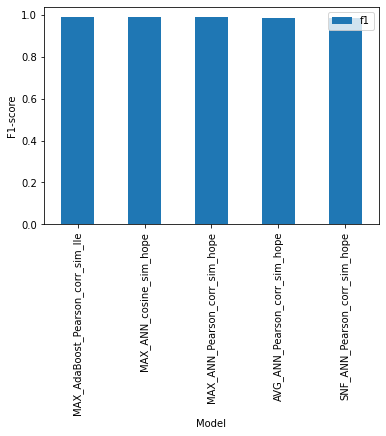

In [ ]:
df_first_5 = sorted_df_by_f1.head(5)
df_first_5 = df_first_5[['model', 'f1']]
df_first_5.plot(x='model', y='f1', kind='bar', xlabel='Model', ylabel='F1-score')